# Earth to Dionysus Trajectory Optimization with SCVX

This notebook demonstrates spacecraft trajectory optimization for Earth-to-Dionysus (asteroid) transfer using Sequential Convex Programming (SCVX) with nonlinearity index-based mesh refinement.

## Features:
- Two-Body dynamics in Modified Equinoctial Elements (MEE)
- Nonlinearity index computation for adaptive mesh refinement
- Trust region optimization with mesh adaptation
- 3D trajectory visualization with nonlinearity indicators
- Thrust profile and mass analysis
- Earth-Dionysus interplanetary transfer optimization

In [1]:
# Import Required Libraries
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import casadi as ca
import time
import sys
import os

# Add the project root to path for clean package imports
# From experiments/E2D/ we need to go up two levels to reach the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))
sys.path.insert(0, project_root)

# Clean package imports - much better!
from dynamics import TwoBodyMEE
from vanilla_dynamics.VanillaTwoBodyDynamics import VanillaTwoBodyMEE
from convexOPT import CVXProgram
from utils import CoordinateConversion

def plot_optimization_progress(program, iteration, AU, TU, t_f_days, m0, c_val, mu, CoordinateConversion):
    """
    Plot comprehensive optimization progress with 4 subplots:
    1. 3D trajectory
    2. Mass profile 
    3. Thrust profile
    4. State error evolution (if vanilla trajectory available)
    """
    # Calculate time steps
    time_normalized = np.concatenate(([0], np.cumsum(program.s.value))) * program.dt
    time_days = time_normalized / TU * 365.25
    
    # Transform tau to proper physical units
    scaling_factor = (np.exp(program.z_p) / 
                     np.concatenate([program.s.value, [program.s.value[-1]]]))
    thrust_control = program.tau.value * scaling_factor[:, np.newaxis]
    thrust_magnitude = np.linalg.norm(thrust_control, axis=1)
    
    # Extract SCVX trajectory
    scvx_trajectory = program.x.value.T
    N_points = scvx_trajectory.shape[1]
    
    # Convert SCVX MEE trajectory to Cartesian for visualization
    scvx_cartesian = np.zeros((6, N_points))
    for i in range(N_points):
        cart = CoordinateConversion.sv_from_mee(scvx_trajectory[:, i], mu)
        scvx_cartesian[:3, i] = cart[:3]
        scvx_cartesian[3:, i] = cart[3:]
    
    # Create subplot figure
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: 3D Trajectory
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot(scvx_cartesian[0, :], scvx_cartesian[1, :], scvx_cartesian[2, :], 
            'b-', linewidth=3, label='SCVX Trajectory', alpha=0.8)
    ax1.scatter(scvx_cartesian[0, 0], scvx_cartesian[1, 0], scvx_cartesian[2, 0], 
               c='green', s=100, marker='o', label='Earth Departure')
    ax1.scatter(scvx_cartesian[0, -1], scvx_cartesian[1, -1], scvx_cartesian[2, -1], 
               c='red', s=100, marker='s', label='Dionysus Arrival')
    ax1.scatter([0], [0], [0], c='yellow', s=200, alpha=0.7, label='Sun')
    ax1.set_xlabel('X (AU)')
    ax1.set_ylabel('Y (AU)')
    ax1.set_zlabel('Z (AU)')
    ax1.set_title(f'3D Trajectory - Iteration {iteration + 1}')
    ax1.legend()
    ax1.view_init(elev=15, azim=45)
    
    # Plot 2: Mass Profile
    ax2 = fig.add_subplot(222)
    mass_profile = np.exp(program.z.value)
    ax2.plot(time_days, mass_profile, 'b-', linewidth=3, alpha=0.8)
    ax2.scatter(0, mass_profile[0], c='green', s=100, marker='o', zorder=5)
    ax2.scatter(time_days[-1], mass_profile[-1], c='red', s=100, marker='s', zorder=5)
    
    propellant_used = m0 - mass_profile[-1]
    ax2.text(0.05, 0.95, f'Initial: {m0:.0f} kg\nFinal: {mass_profile[-1]:.1f} kg\nPropellant: {propellant_used:.1f} kg', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8), 
             verticalalignment='top')
    
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Mass (kg)')
    ax2.set_title('Mass Profile')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Thrust Profile
    ax3 = fig.add_subplot(223)
    ax3.plot(time_days, thrust_magnitude, 'g-', linewidth=2)
    ax3.scatter(time_days, thrust_magnitude, c='red', s=20, alpha=0.7)
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Thrust Magnitude')
    ax3.set_title('Thrust Profile')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Placeholder for state error (will be filled during vanilla comparison)
    ax4 = fig.add_subplot(224)
    ax4.text(0.5, 0.5, 'State Error Evolution\n(Available after vanilla comparison)', 
             horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes,
             bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))
    ax4.set_xlabel('Time (days)')
    ax4.set_ylabel('State Error')
    ax4.set_title('State Error Evolution')
    
    plt.tight_layout()
    plt.show()

def plot_comprehensive_comparison(program, scvx_trajectory, vanilla_trajectory, vanilla_mass, 
                                time_scvx, thrust_control, AU, TU, t_f_days, m0, mu, CoordinateConversion):
    """
    Plot comprehensive SCVX vs Vanilla trajectory comparison with 4 subplots:
    1. 3D trajectory comparison
    2. Mass profile comparison
    3. Thrust profile
    4. State error evolution
    """
    N_points = scvx_trajectory.shape[1]
    time_days = time_scvx / TU * 365.25
    
    # Convert trajectories to Cartesian
    scvx_cartesian = np.zeros((6, N_points))
    vanilla_cartesian = np.zeros((6, len(time_scvx)))
    
    for i in range(N_points):
        cart = CoordinateConversion.sv_from_mee(scvx_trajectory[:, i], mu)
        scvx_cartesian[:3, i] = cart[:3]
        scvx_cartesian[3:, i] = cart[3:]
        
    for i in range(len(time_scvx)):
        cart = CoordinateConversion.sv_from_mee(vanilla_trajectory[:, i], mu)
        vanilla_cartesian[:3, i] = cart[:3]
        vanilla_cartesian[3:, i] = cart[3:]
    
    # Calculate state errors
    state_errors = np.linalg.norm(scvx_trajectory - vanilla_trajectory, axis=0)
    thrust_magnitude = np.linalg.norm(thrust_control, axis=1)
    
    # Create subplot figure
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: 3D Trajectory Comparison
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot(scvx_cartesian[0, :], scvx_cartesian[1, :], scvx_cartesian[2, :], 
            'b-', linewidth=3, label='SCVX Optimized', alpha=0.8)
    ax1.plot(vanilla_cartesian[0, :], vanilla_cartesian[1, :], vanilla_cartesian[2, :], 
            'r--', linewidth=2, label='Vanilla Two-Body', alpha=0.8)
    ax1.scatter(scvx_cartesian[0, 0], scvx_cartesian[1, 0], scvx_cartesian[2, 0], 
               c='green', s=100, marker='o', label='Earth Departure')
    ax1.scatter(scvx_cartesian[0, -1], scvx_cartesian[1, -1], scvx_cartesian[2, -1], 
               c='red', s=100, marker='s', label='Dionysus Arrival')
    ax1.scatter([0], [0], [0], c='yellow', s=200, alpha=0.7, label='Sun')
    ax1.set_xlabel('X (AU)')
    ax1.set_ylabel('Y (AU)')
    ax1.set_zlabel('Z (AU)')
    ax1.set_title('SCVX vs Vanilla Two-Body Trajectory')
    ax1.legend()
    ax1.view_init(elev=15, azim=45)
    
    # Plot 2: Mass Profile Comparison
    ax2 = fig.add_subplot(222)
    scvx_mass_profile = np.exp(program.z.value)
    ax2.plot(time_days, scvx_mass_profile, 'b-', linewidth=3, label='SCVX Mass', alpha=0.8)
    ax2.plot(time_days, vanilla_mass, 'r--', linewidth=2, label='Vanilla Mass', alpha=0.8)
    ax2.scatter(0, scvx_mass_profile[0], c='green', s=100, marker='o', zorder=5)
    ax2.scatter(time_days[-1], scvx_mass_profile[-1], c='blue', s=100, marker='s', zorder=5)
    ax2.scatter(time_days[-1], vanilla_mass[-1], c='red', s=100, marker='s', zorder=5)
    
    propellant_used_scvx = m0 - scvx_mass_profile[-1]
    propellant_used_vanilla = m0 - vanilla_mass[-1]
    ax2.text(0.05, 0.95, f'SCVX: {m0:.0f}→{scvx_mass_profile[-1]:.1f} kg\nPropellant: {propellant_used_scvx:.1f} kg', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8), 
             verticalalignment='top')
    ax2.text(0.05, 0.75, f'Vanilla: {m0:.0f}→{vanilla_mass[-1]:.1f} kg\nPropellant: {propellant_used_vanilla:.1f} kg', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8), 
             verticalalignment='top')
    
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Mass (kg)')
    ax2.set_title('Mass Profile Comparison')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Thrust Profile
    ax3 = fig.add_subplot(223)
    ax3.plot(time_days, thrust_magnitude, 'g-', linewidth=2)
    ax3.scatter(time_days, thrust_magnitude, c='red', s=20, alpha=0.7)
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Thrust Magnitude')
    ax3.set_title('Thrust Profile')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: State Error Evolution
    ax4 = fig.add_subplot(224)
    ax4.semilogy(time_days, state_errors, 'purple', linewidth=2)
    ax4.set_xlabel('Time (days)')
    ax4.set_ylabel('MEE State Error')
    ax4.set_title('State Error Evolution')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return propellant_used_scvx, propellant_used_vanilla, state_errors

In [2]:
# Set Physical Parameters and Constants for Earth-Dionysus Transfer

# Characteristic units for Earth-Dionysus system
AU = 149597870.69100001454  # Astronomical Unit in km
AUm = AU * 1e3  # AU in meters
TU = 31536000 / (2 * np.pi)  # Time unit (s)

# Gravitational parameter of the Sun (normalized)
mu = 132712440041.93899536 / (AU ** 3) * (TU ** 2)

# Spacecraft parameters
m0 = 4000  # initial mass (kg)
g0 = 9.8065  # gravitational acceleration (m/s^2)
I_sp = 3000  # specific impulse (s)

# Thrust calculations
T_max = 0.32 / AUm * (TU ** 2)  # maximum thrust (normalized)

# Effective exhaust velocity (normalized)
c_val = I_sp * g0 / AUm * TU

# Initial position and velocity vectors (normalized to AU and AU/TU)
r_i = np.array([-3637871.081, 147099798.784, -2261.441]) / AU
v_i = np.array([-30.265097, -0.8486854, 0.0000505]) / AU * TU

# Final position and velocity vectors (normalized to AU and AU/TU)
r_f = np.array([-302452014.884, 316097179.632, 82872290.0755]) / AU
v_f = np.array([-4.533473, -13.110309, 0.656163]) / AU * TU

# Mission time parameters
t_f_days = 3534  # mission duration in days
t_f = t_f_days * 24 * 3600 / TU  # mission duration (normalized)

# Discretization parameters
N = 600  # number of discretization points
dt = t_f / (N - 1)  # time step

# Mass parameters
m_f_estimated = 2500  # estimated final mass (kg)
z_0 = np.log(m0)  # initial log mass
z_f_estimated = np.log(m_f_estimated)  # estimated final log mass
init_z_map = np.linspace(z_0, z_f_estimated, N)  # log mass profile

In [3]:
# Convert Initial and Final Conditions to Modified Equinoctial Elements

# Convert initial and final states from position-velocity (rv) to modified equinoctial elements (mee)
# Using standalone functions from CoordinateConversion module
x_i = CoordinateConversion.mee_from_sv(r_i, v_i, mu)
x_f = CoordinateConversion.mee_from_sv(r_f, v_f, mu)

# Adjust final true longitude (theta) to ensure a smooth transition
# For long-duration missions to asteroids, multiple orbit wraps may be needed
x_f[-1] += 12 * np.pi

# Initial trajectory guess (linear interpolation in MEE space)
init_traj = np.linspace(x_i, x_f, N)

In [4]:
# Initialize Two-Body Dynamics Classes

# Create full dynamics instance for optimization (includes time dilation and derivatives)
# Use 6-dimensional MEE state: [p, f, g, h, k, L]
# Mass is handled separately in SCVX through z variable
twobody_dynamics = TwoBodyMEE()  # Default n_x=6, n_u=3
twobody_dynamics.set_params(c=c_val)
twobody_dynamics.compile()

# Create vanilla dynamics instance for uncontrolled propagation (simpler, faster)
vanilla_twobody = VanillaTwoBodyMEE()
vanilla_twobody.set_params(c=c_val)
vanilla_twobody.compile()

# Control vector for uncontrolled propagation
zero_control = np.zeros(3)

# Constant mass for vanilla dynamics (not used in optimization)
constant_mass = m0

# Define ODE function for integration using vanilla dynamics
def ode(t, x):
    """
    ODE function for spacecraft dynamics in Two-Body problem (uncontrolled).
    
    Args:
        t: Time (unused for autonomous system)
        x: State vector [p, f, g, h, k, L] (6-dimensional MEE)
    
    Returns:
        State derivative vector
    """
    return vanilla_twobody.state_dot(x, zero_control, constant_mass)

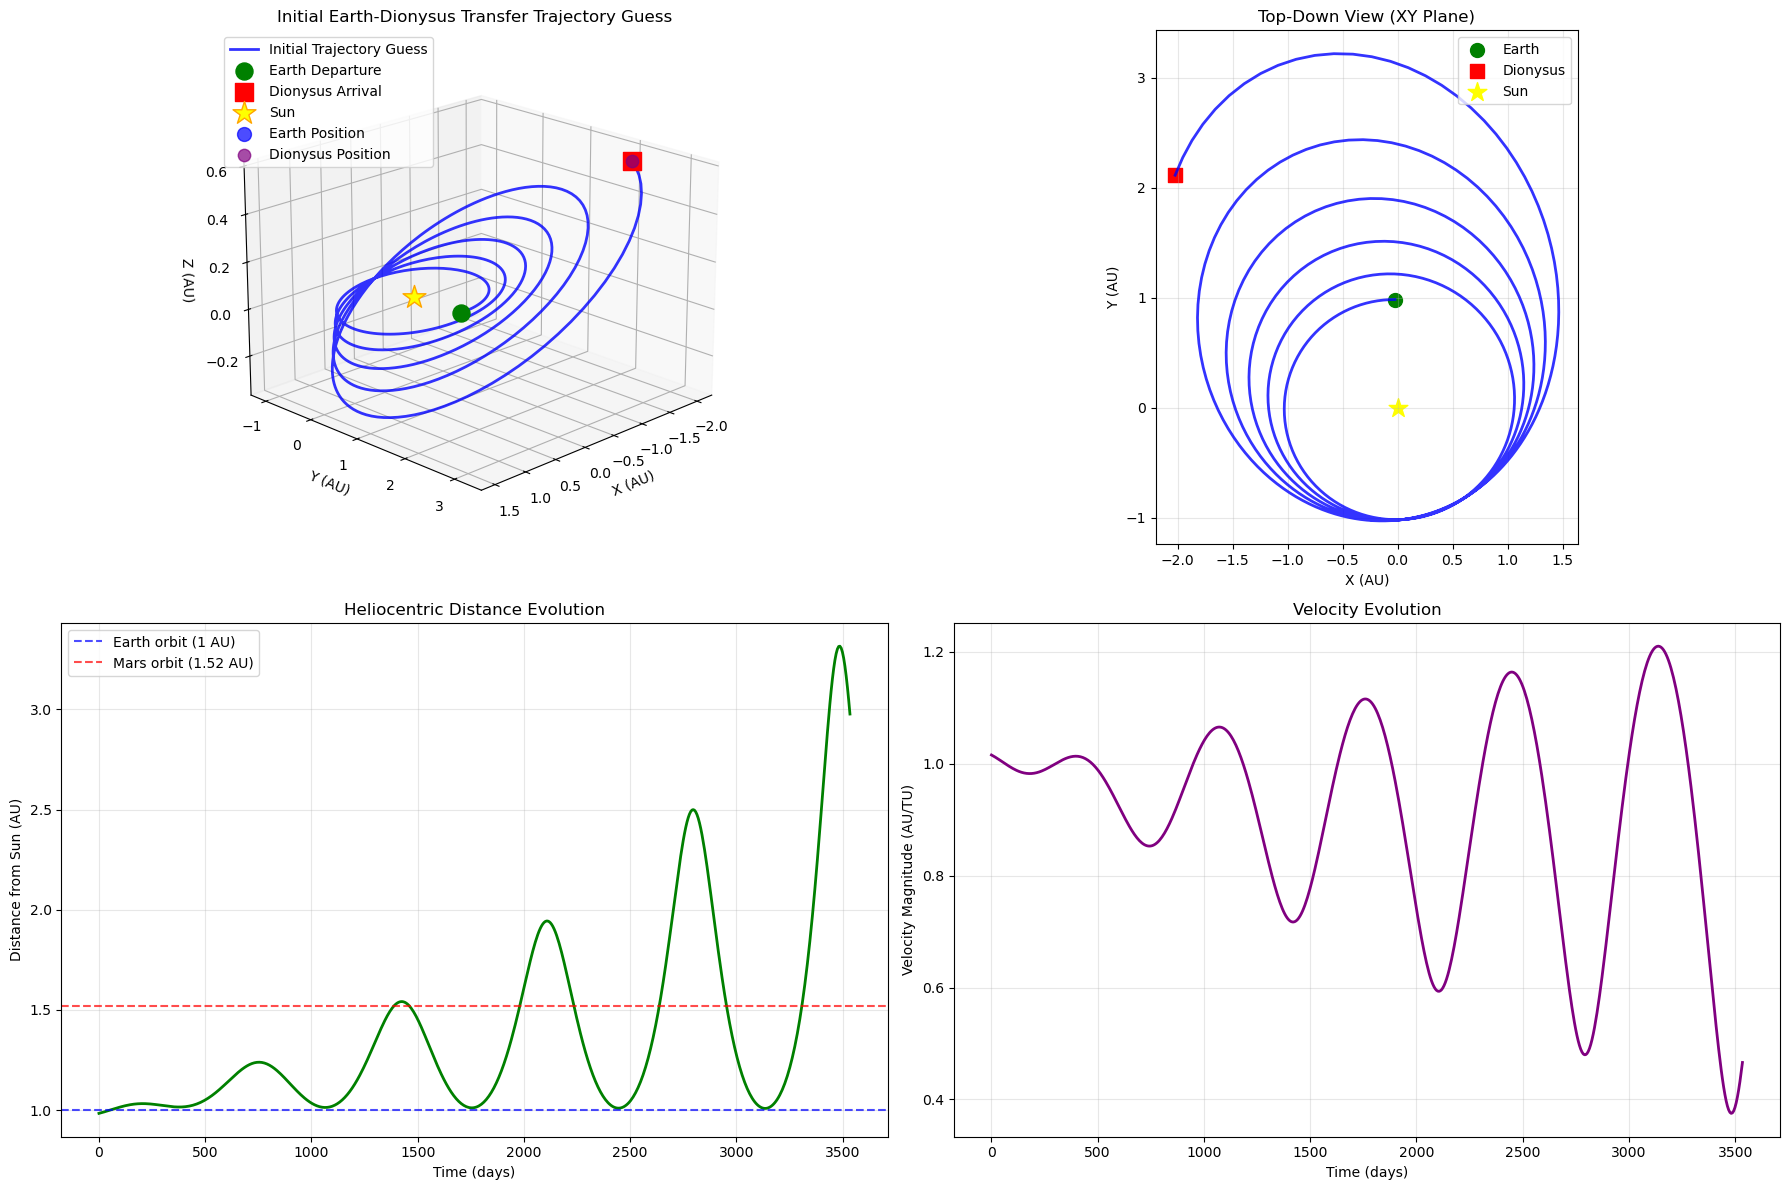

In [5]:
# Visualize Initial Trajectory Guess

# Convert MEE trajectory to Cartesian for visualization
cartesian_traj = np.zeros((N, 6))  # [rx, ry, rz, vx, vy, vz]

for i in range(N):
    # Convert each MEE state to Cartesian
    cart = CoordinateConversion.sv_from_mee(init_traj[i], mu)
    cartesian_traj[i, :3] = cart[:3]  # position
    cartesian_traj[i, 3:] = cart[3:]  # velocity

# Create comprehensive trajectory visualization
fig = plt.figure(figsize=(18, 12))

# Main 3D trajectory plot
ax1 = fig.add_subplot(221, projection='3d')

# Plot initial trajectory guess
ax1.plot(cartesian_traj[:, 0], cartesian_traj[:, 1], cartesian_traj[:, 2], 
        'b-', linewidth=2, label='Initial Trajectory Guess', alpha=0.8)

# Mark start and end points
ax1.scatter(cartesian_traj[0, 0], cartesian_traj[0, 1], cartesian_traj[0, 2], 
           c='green', s=150, marker='o', label='Earth Departure')
ax1.scatter(cartesian_traj[-1, 0], cartesian_traj[-1, 1], cartesian_traj[-1, 2], 
           c='red', s=150, marker='s', label='Dionysus Arrival')

# Plot Sun at origin
ax1.scatter([0], [0], [0], c='yellow', s=300, marker='*', label='Sun', edgecolors='orange')

# Add Earth and Dionysus positions
ax1.scatter([r_i[0]], [r_i[1]], [r_i[2]], 
           c='blue', s=100, alpha=0.7, label='Earth Position')
ax1.scatter([r_f[0]], [r_f[1]], [r_f[2]], 
           c='purple', s=80, alpha=0.7, label='Dionysus Position')

ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')
ax1.set_zlabel('Z (AU)')
ax1.set_title('Initial Earth-Dionysus Transfer Trajectory Guess')
ax1.view_init(elev=20, azim=45)
ax1.legend()

# Top-down view (XY plane)
ax2 = fig.add_subplot(222)
ax2.plot(cartesian_traj[:, 0], cartesian_traj[:, 1], 'b-', linewidth=2, alpha=0.8)
ax2.scatter(cartesian_traj[0, 0], cartesian_traj[0, 1], c='green', s=100, marker='o', label='Earth')
ax2.scatter(cartesian_traj[-1, 0], cartesian_traj[-1, 1], c='red', s=100, marker='s', label='Dionysus')
ax2.scatter([0], [0], c='yellow', s=200, marker='*', label='Sun')
ax2.set_xlabel('X (AU)')
ax2.set_ylabel('Y (AU)')
ax2.set_title('Top-Down View (XY Plane)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_aspect('equal')

# Mission timeline
ax3 = fig.add_subplot(223)
time_days = np.linspace(0, t_f_days, N)
distance_to_sun = np.linalg.norm(cartesian_traj[:, :3], axis=1)
ax3.plot(time_days, distance_to_sun, 'g-', linewidth=2)
ax3.axhline(y=1.0, color='blue', linestyle='--', alpha=0.7, label='Earth orbit (1 AU)')
ax3.axhline(y=1.52, color='red', linestyle='--', alpha=0.7, label='Mars orbit (1.52 AU)')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Distance from Sun (AU)')
ax3.set_title('Heliocentric Distance Evolution')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Velocity evolution
ax4 = fig.add_subplot(224)
velocity_magnitude = np.linalg.norm(cartesian_traj[:, 3:], axis=1)
ax4.plot(time_days, velocity_magnitude, 'purple', linewidth=2)
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Velocity Magnitude (AU/TU)')
ax4.set_title('Velocity Evolution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Set Up SCVX Optimization Program

# Create CVX program with nonlinearity index and mesh refinement
# Note: For long-duration missions, we may need adjusted parameters
program = CVXProgram(
    dynamics=twobody_dynamics,
    N=N,
    t_f=t_f,
    T_max=T_max,
    c=c_val,
    x_i=x_i,          # 6-dimensional MEE initial state
    x_f=x_f,          # 6-dimensional MEE final state
    z_0=z_0,          # Initial log mass
    init_traj=init_traj,  # 6-dimensional MEE trajectory
    init_z_map=init_z_map,  # Log mass profile
    trust_region_mode='nonlinear_idx',     # Enable nonlinearity index
    mesh_refinement_enabled=True,          # Enable adaptive mesh refinement
    rho0=0.04, rho1=0.2, rho2=0.7,      # More conservative trust region updates
    alpha=1.5, beta=1.5,                  # More conservative scaling factors
    # Optimization parameters
    tolerance=1e-4,                       # Convergence tolerance
    C=5.0,            # Penalty parameter
    nonlinear_idx_multiplier=1/30,       # Reduced nonlinearity index weight for stability
    # Constraint parameters
    mul_min_clamp=1.0,                   # More conservative multiplier clamps
    mul_max_clamp=3.0,                   # for long-duration missions
    trust_region_values = np.array([1e1, 1e-1, 1e1, 1e0, 1e0, 1e1, 1e-1])
)

# Run initial optimization
try:
    result = program.optimize()
except Exception as e:
    result = False

/media/potato/New Volume/Auburn/scvx_mesh_ref_nonlinearity_idx/convexOPT/SCVX.py:245: RuntimeWarning: divide by zero encountered in divide
  mul = np.maximum(np.minimum(self.nonlinear_idx_multiplier / nonlinear,
/home/potato/anaconda3/envs/aero/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/potato/anaconda3/envs/aero/lib/python3.11/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,
/home/potato/anaconda3/envs/aero/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/potat

--- Iteration 1 ---
Linear cost: 1.061990e+00
Nonlinear cost: 1.531612e+02
Linear cost: 1.061990e+00
Nonlinear cost: 1.531612e+02


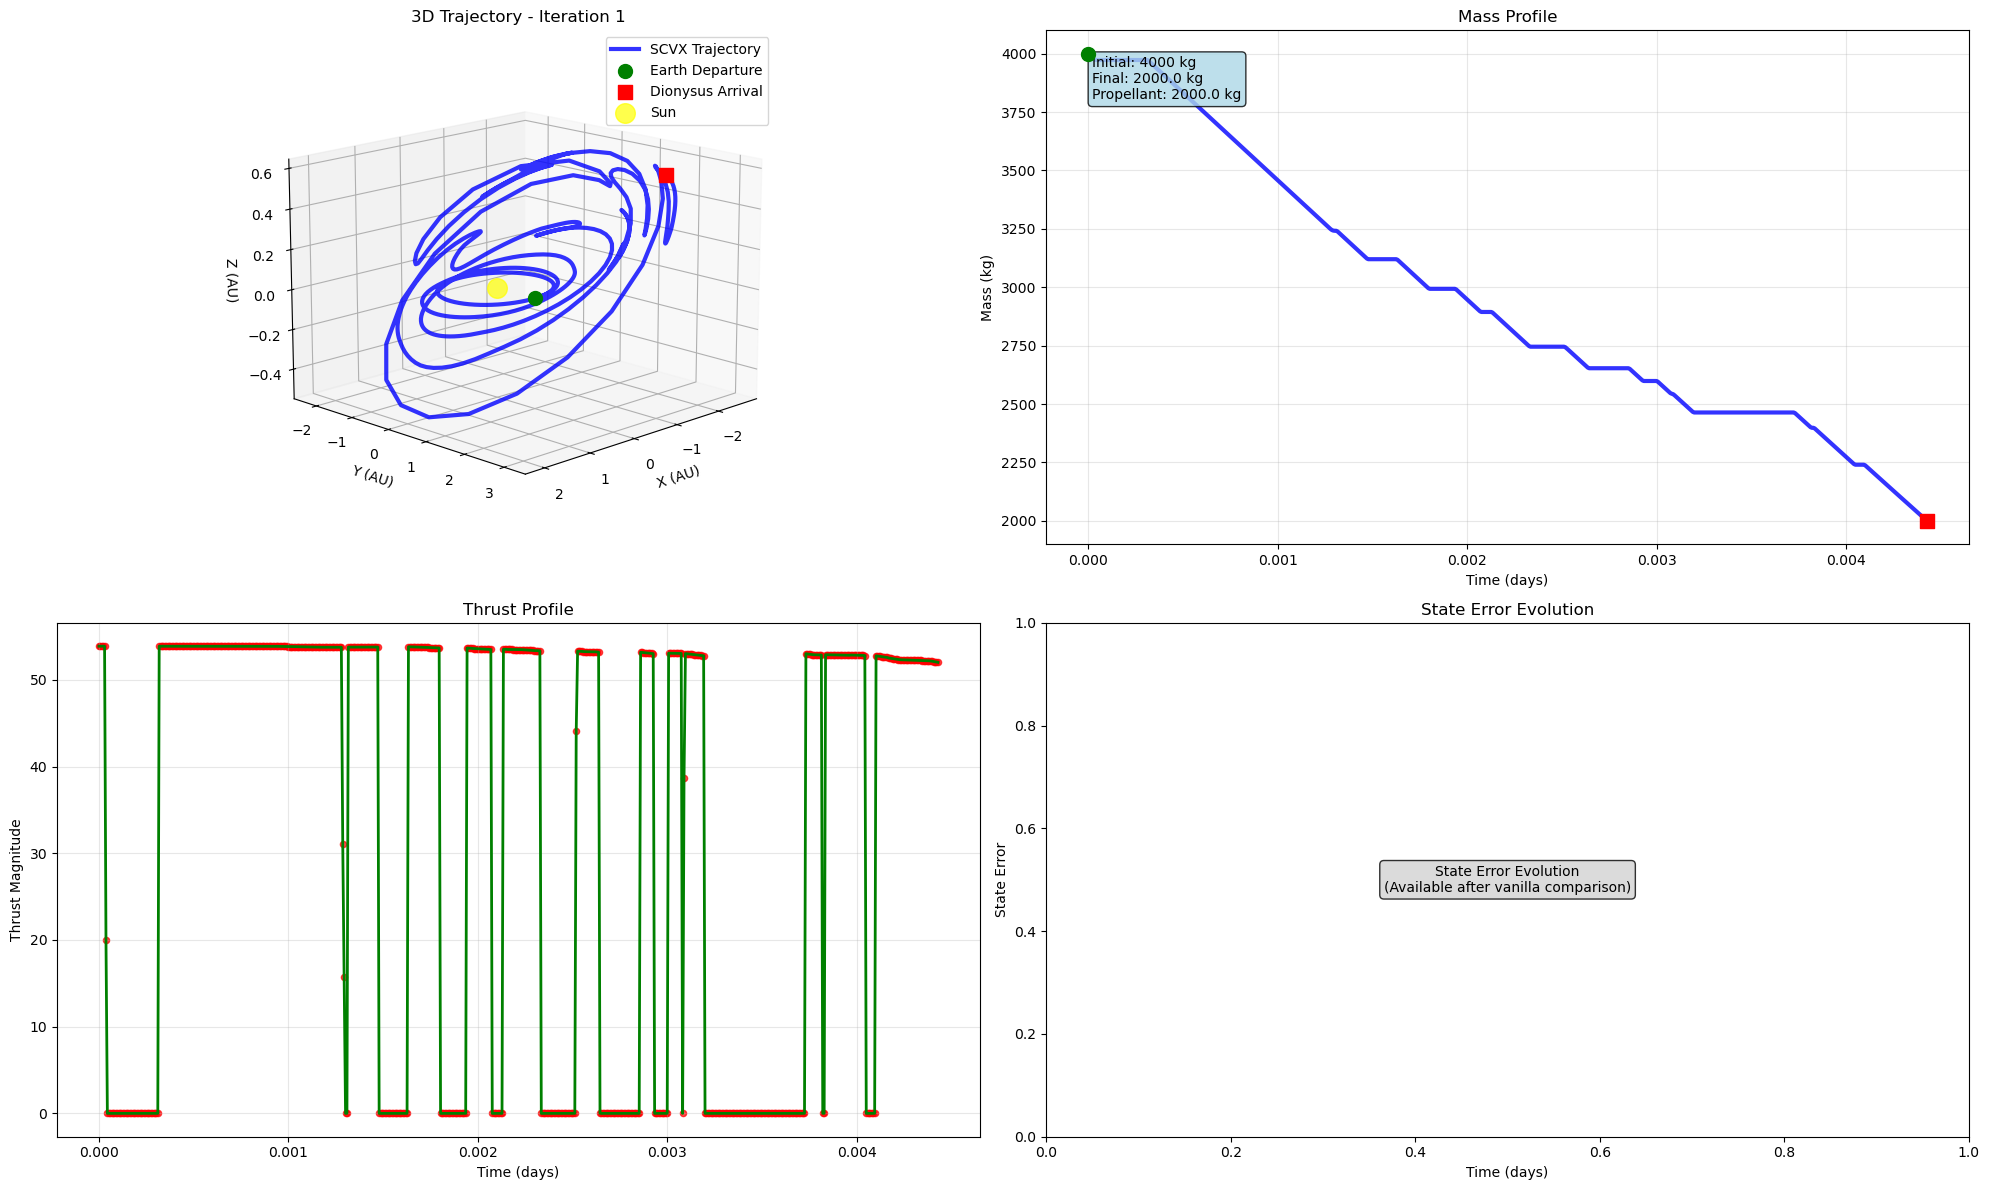

Iteration 1 completed. Converged: False
--- Iteration 2 ---
Linear cost: 5.965728e-01
Nonlinear cost: 5.445664e+01
Iteration 2 completed. Converged: False
--- Iteration 3 ---
Linear cost: 5.965728e-01
Nonlinear cost: 5.445664e+01
Iteration 2 completed. Converged: False
--- Iteration 3 ---
Linear cost: 3.775485e-01
Nonlinear cost: 2.578873e+01
Iteration 3 completed. Converged: False
--- Iteration 4 ---
Linear cost: 3.775485e-01
Nonlinear cost: 2.578873e+01
Iteration 3 completed. Converged: False
--- Iteration 4 ---
Linear cost: 3.557834e-01
Nonlinear cost: 2.020760e+01
Iteration 4 completed. Converged: False
--- Iteration 5 ---
Linear cost: 3.557834e-01
Nonlinear cost: 2.020760e+01
Iteration 4 completed. Converged: False
--- Iteration 5 ---
Linear cost: 3.850727e-01
Nonlinear cost: 1.194479e+01
Iteration 5 completed. Converged: False
--- Iteration 6 ---
Linear cost: 3.850727e-01
Nonlinear cost: 1.194479e+01
Iteration 5 completed. Converged: False
--- Iteration 6 ---
Linear cost: 3.81166

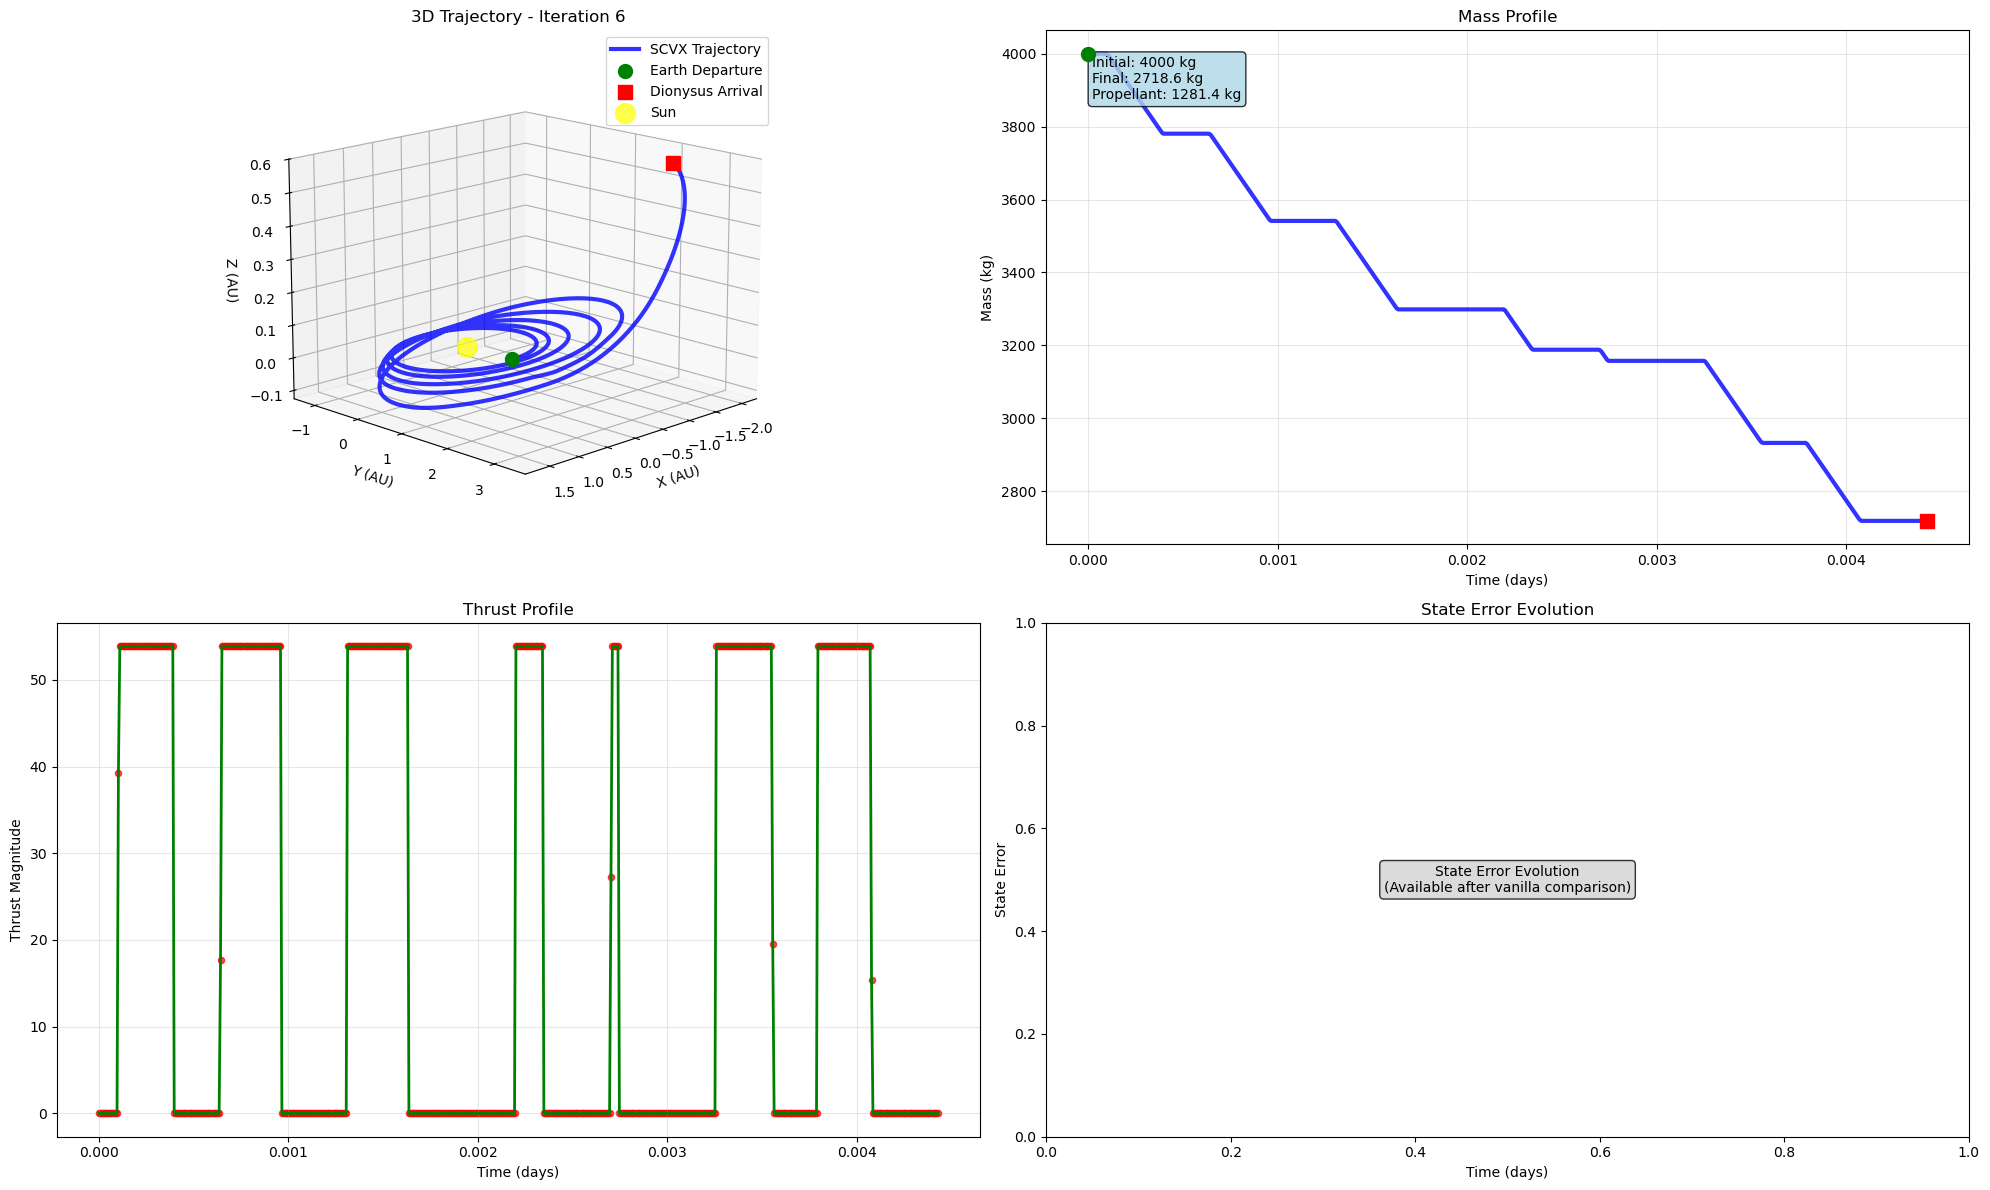

Iteration 6 completed. Converged: False
--- Iteration 7 ---
Linear cost: 3.719836e-01
Nonlinear cost: 7.324460e+00
Iteration 7 completed. Converged: False
--- Iteration 8 ---
Linear cost: 3.719836e-01
Nonlinear cost: 7.324460e+00
Iteration 7 completed. Converged: False
--- Iteration 8 ---
Linear cost: 3.734967e-01
Nonlinear cost: 4.815807e+00
Iteration 8 completed. Converged: False
--- Iteration 9 ---
Linear cost: 3.734967e-01
Nonlinear cost: 4.815807e+00
Iteration 8 completed. Converged: False
--- Iteration 9 ---
Linear cost: 3.658989e-01
Nonlinear cost: 4.445934e+00
Iteration 9 completed. Converged: False
--- Iteration 10 ---
Linear cost: 3.658989e-01
Nonlinear cost: 4.445934e+00
Iteration 9 completed. Converged: False
--- Iteration 10 ---
Linear cost: 3.719154e-01
Nonlinear cost: 4.081227e+00
Iteration 10 completed. Converged: False
--- Iteration 11 ---
Linear cost: 3.719154e-01
Nonlinear cost: 4.081227e+00
Iteration 10 completed. Converged: False
--- Iteration 11 ---
Linear cost: 3

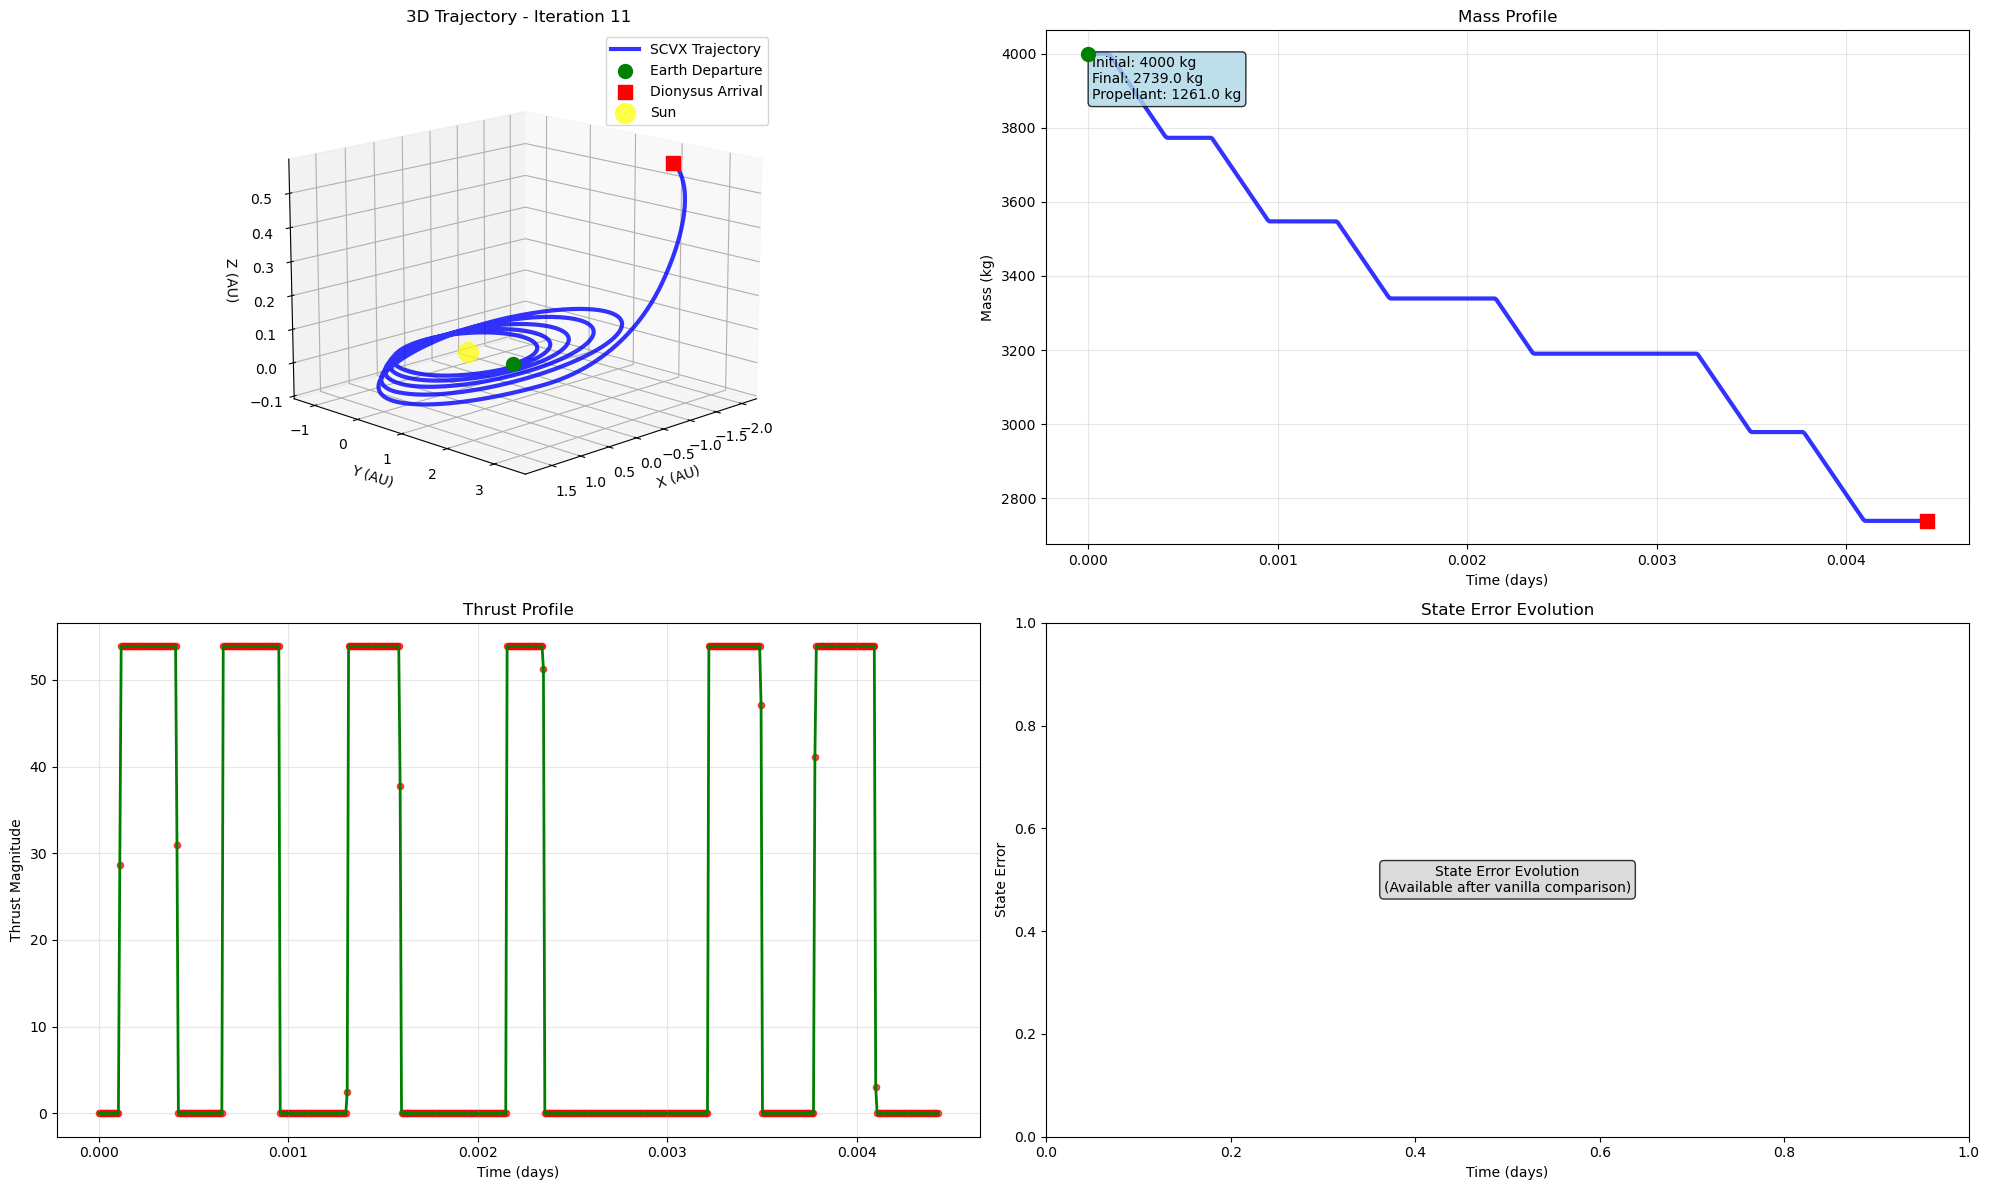

Iteration 11 completed. Converged: False
--- Iteration 12 ---
Linear cost: 3.782759e-01
Nonlinear cost: 1.483087e+00
Iteration 12 completed. Converged: False
--- Iteration 13 ---
Linear cost: 3.782759e-01
Nonlinear cost: 1.483087e+00
Iteration 12 completed. Converged: False
--- Iteration 13 ---
Linear cost: 3.801385e-01
Nonlinear cost: 1.015439e+00
Iteration 13 completed. Converged: False
--- Iteration 14 ---
Linear cost: 3.801385e-01
Nonlinear cost: 1.015439e+00
Iteration 13 completed. Converged: False
--- Iteration 14 ---
Linear cost: 3.791684e-01
Nonlinear cost: 1.203126e+00
Iteration 14 completed. Converged: False
--- Iteration 15 ---
Linear cost: 3.791684e-01
Nonlinear cost: 1.203126e+00
Iteration 14 completed. Converged: False
--- Iteration 15 ---
Linear cost: 3.801721e-01
Nonlinear cost: 7.491505e-01
Iteration 15 completed. Converged: False
--- Iteration 16 ---
Linear cost: 3.801721e-01
Nonlinear cost: 7.491505e-01
Iteration 15 completed. Converged: False
--- Iteration 16 ---
Li

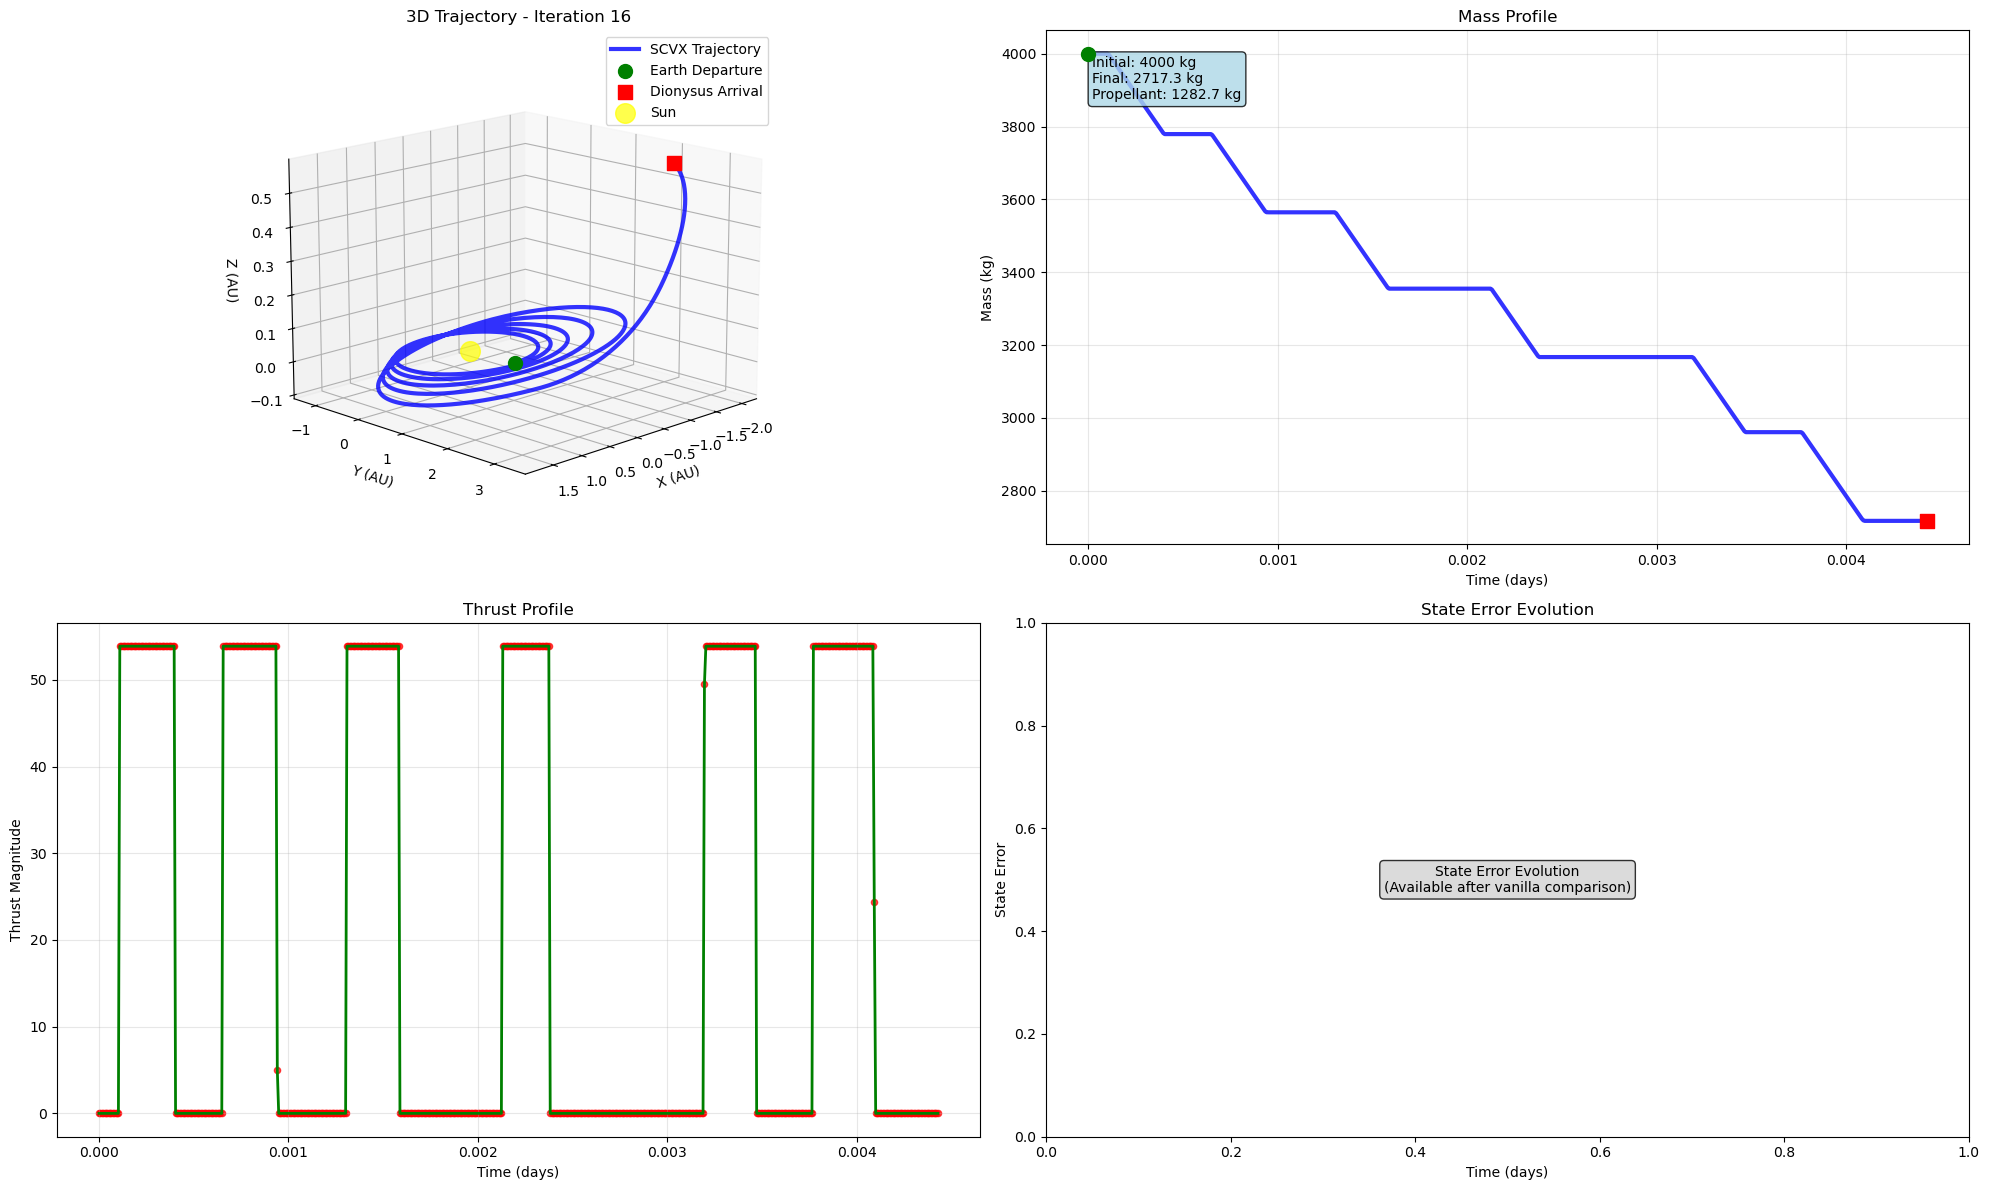

Iteration 16 completed. Converged: False
--- Iteration 17 ---
Linear cost: 3.814344e-01
Nonlinear cost: 6.677096e-01
Iteration 17 completed. Converged: False
--- Iteration 18 ---
Linear cost: 3.814344e-01
Nonlinear cost: 6.677096e-01
Iteration 17 completed. Converged: False
--- Iteration 18 ---
Linear cost: 3.814448e-01
Nonlinear cost: 6.654742e-01
Iteration 18 completed. Converged: False
--- Iteration 19 ---
Linear cost: 3.814448e-01
Nonlinear cost: 6.654742e-01
Iteration 18 completed. Converged: False
--- Iteration 19 ---
Linear cost: 3.814881e-01
Nonlinear cost: 5.224898e-01
Iteration 19 completed. Converged: False
--- Iteration 20 ---
Linear cost: 3.814881e-01
Nonlinear cost: 5.224898e-01
Iteration 19 completed. Converged: False
--- Iteration 20 ---
Linear cost: 3.814005e-01
Nonlinear cost: 4.899445e-01
Iteration 20 completed. Converged: False
--- Iteration 21 ---
Linear cost: 3.814005e-01
Nonlinear cost: 4.899445e-01
Iteration 20 completed. Converged: False
--- Iteration 21 ---
Li

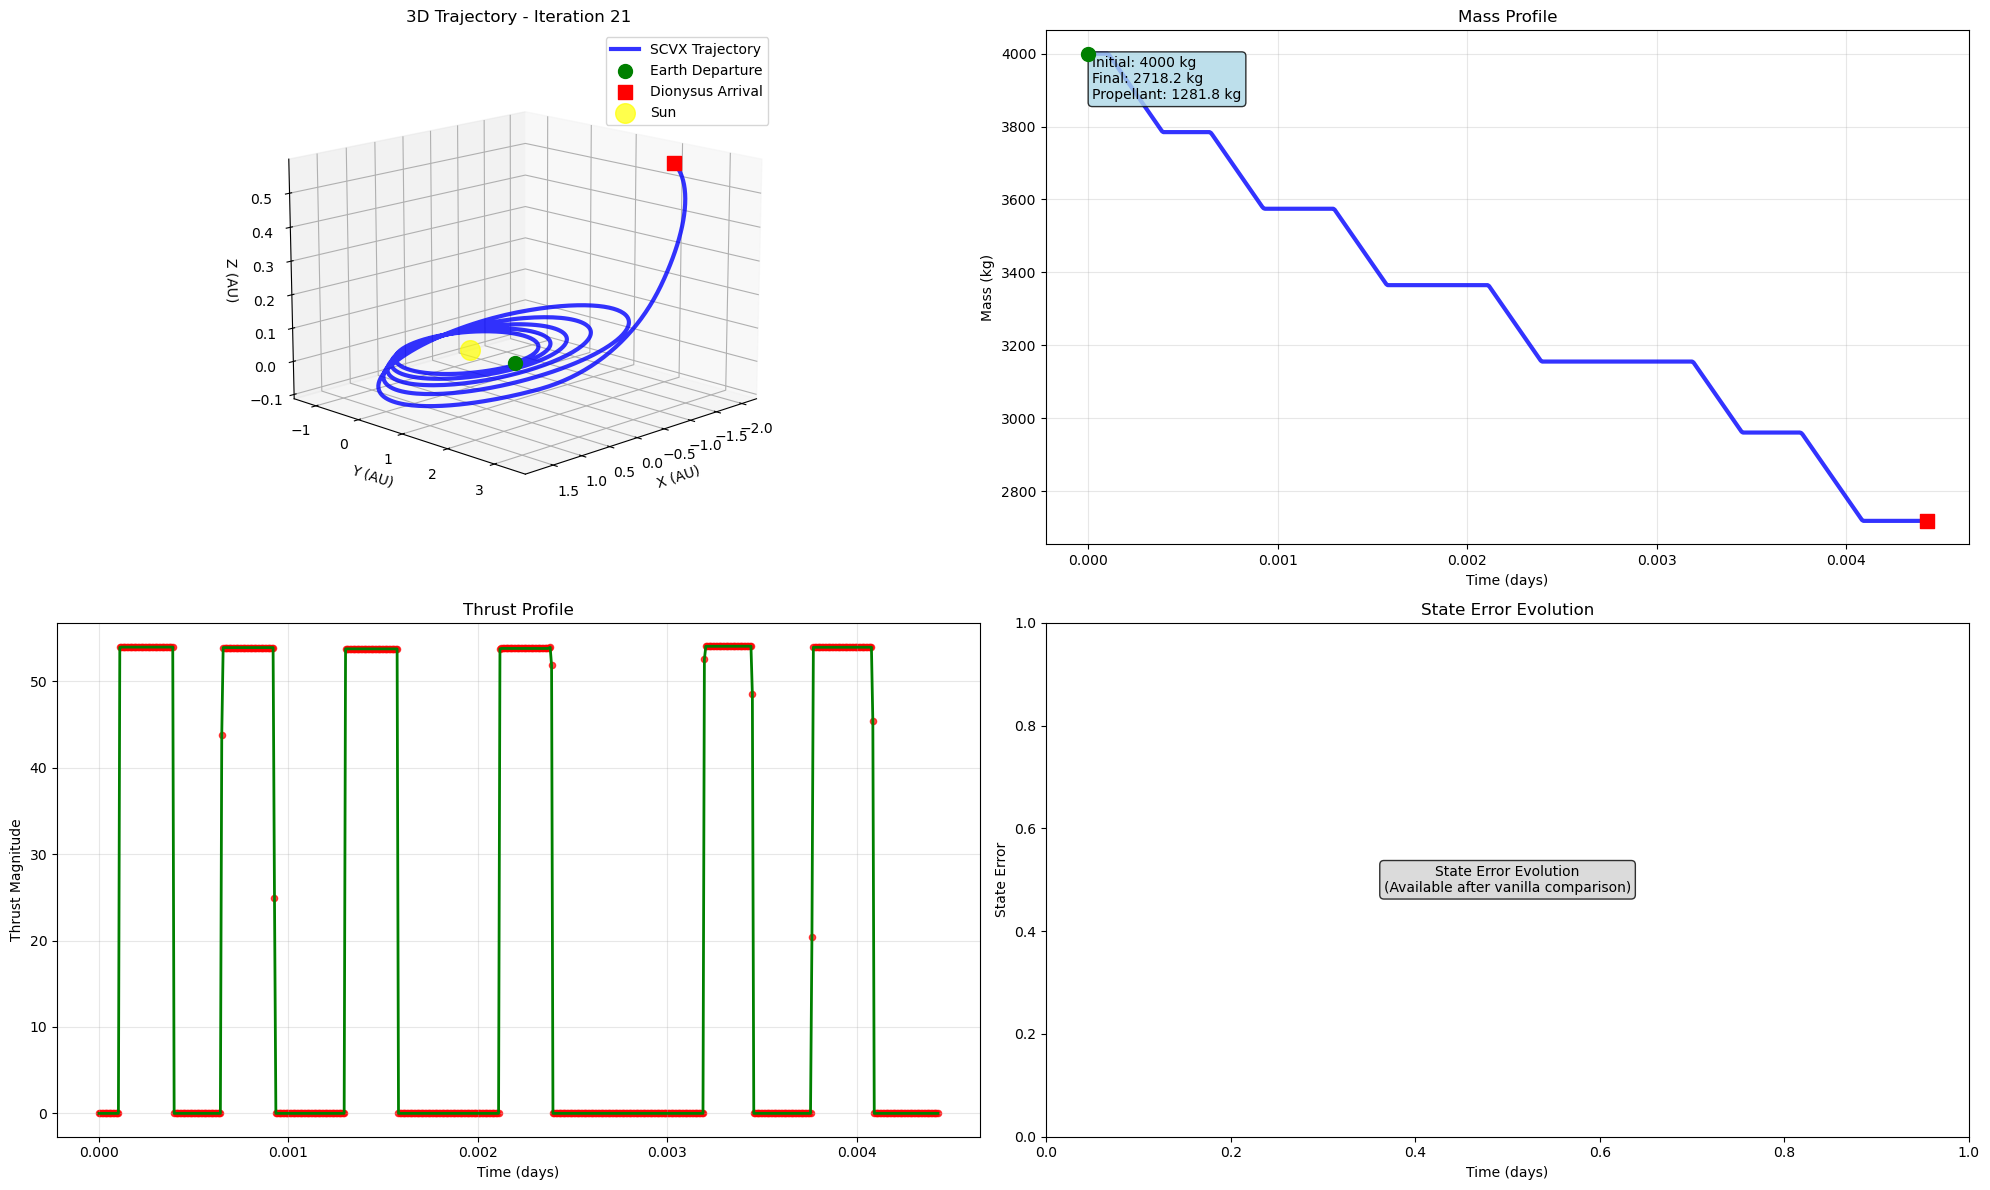

Iteration 21 completed. Converged: False
--- Iteration 22 ---
Linear cost: 3.815079e-01
Nonlinear cost: 4.451906e-01
Iteration 22 completed. Converged: False
--- Iteration 23 ---
Linear cost: 3.815079e-01
Nonlinear cost: 4.451906e-01
Iteration 22 completed. Converged: False
--- Iteration 23 ---
Linear cost: 3.817774e-01
Nonlinear cost: 3.949753e-01
Iteration 23 completed. Converged: False
--- Iteration 24 ---
Linear cost: 3.817774e-01
Nonlinear cost: 3.949753e-01
Iteration 23 completed. Converged: False
--- Iteration 24 ---
Linear cost: 3.816707e-01
Nonlinear cost: 4.347248e-01
Iteration 24 completed. Converged: False
--- Iteration 25 ---
Linear cost: 3.816707e-01
Nonlinear cost: 4.347248e-01
Iteration 24 completed. Converged: False
--- Iteration 25 ---
Linear cost: 3.816775e-01
Nonlinear cost: 4.322618e-01
Iteration 25 completed. Converged: False
--- Iteration 26 ---
Linear cost: 3.816775e-01
Nonlinear cost: 4.322618e-01
Iteration 25 completed. Converged: False
--- Iteration 26 ---
Li

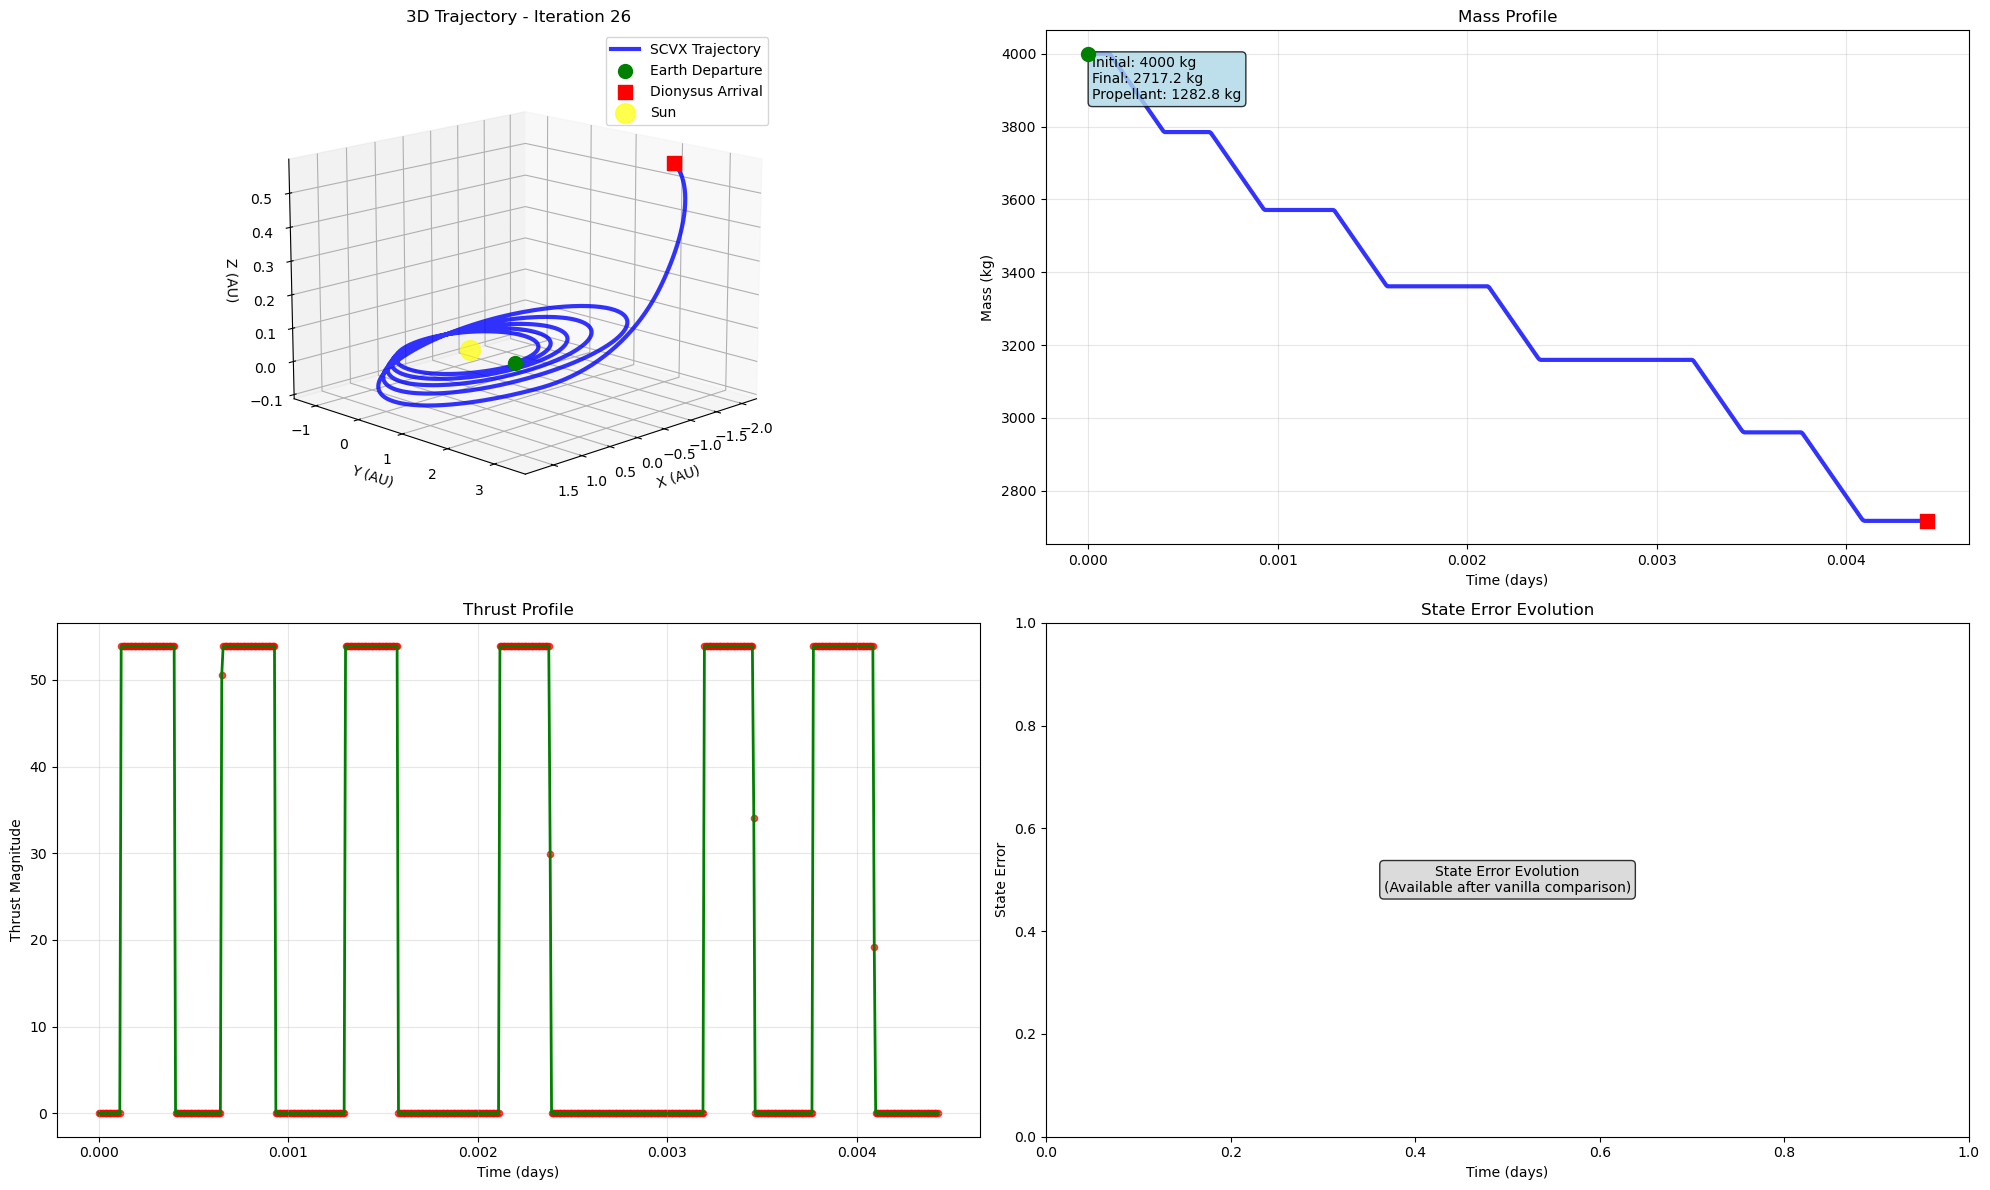

Iteration 26 completed. Converged: False
--- Iteration 27 ---
Linear cost: 3.817758e-01
Nonlinear cost: 4.024178e-01
Iteration 27 completed. Converged: False
--- Iteration 28 ---
Linear cost: 3.817758e-01
Nonlinear cost: 4.024178e-01
Iteration 27 completed. Converged: False
--- Iteration 28 ---
Linear cost: 3.817522e-01
Nonlinear cost: 3.984469e-01
Iteration 28 completed. Converged: False
--- Iteration 29 ---
Linear cost: 3.817522e-01
Nonlinear cost: 3.984469e-01
Iteration 28 completed. Converged: False
--- Iteration 29 ---
Linear cost: 3.817884e-01
Nonlinear cost: 3.891583e-01
Iteration 29 completed. Converged: False
--- Iteration 30 ---
Linear cost: 3.817884e-01
Nonlinear cost: 3.891583e-01
Iteration 29 completed. Converged: False
--- Iteration 30 ---
Linear cost: 3.817848e-01
Nonlinear cost: 3.888944e-01
Iteration 30 completed. Converged: False
--- Iteration 31 ---
Linear cost: 3.817848e-01
Nonlinear cost: 3.888944e-01
Iteration 30 completed. Converged: False
--- Iteration 31 ---
Li

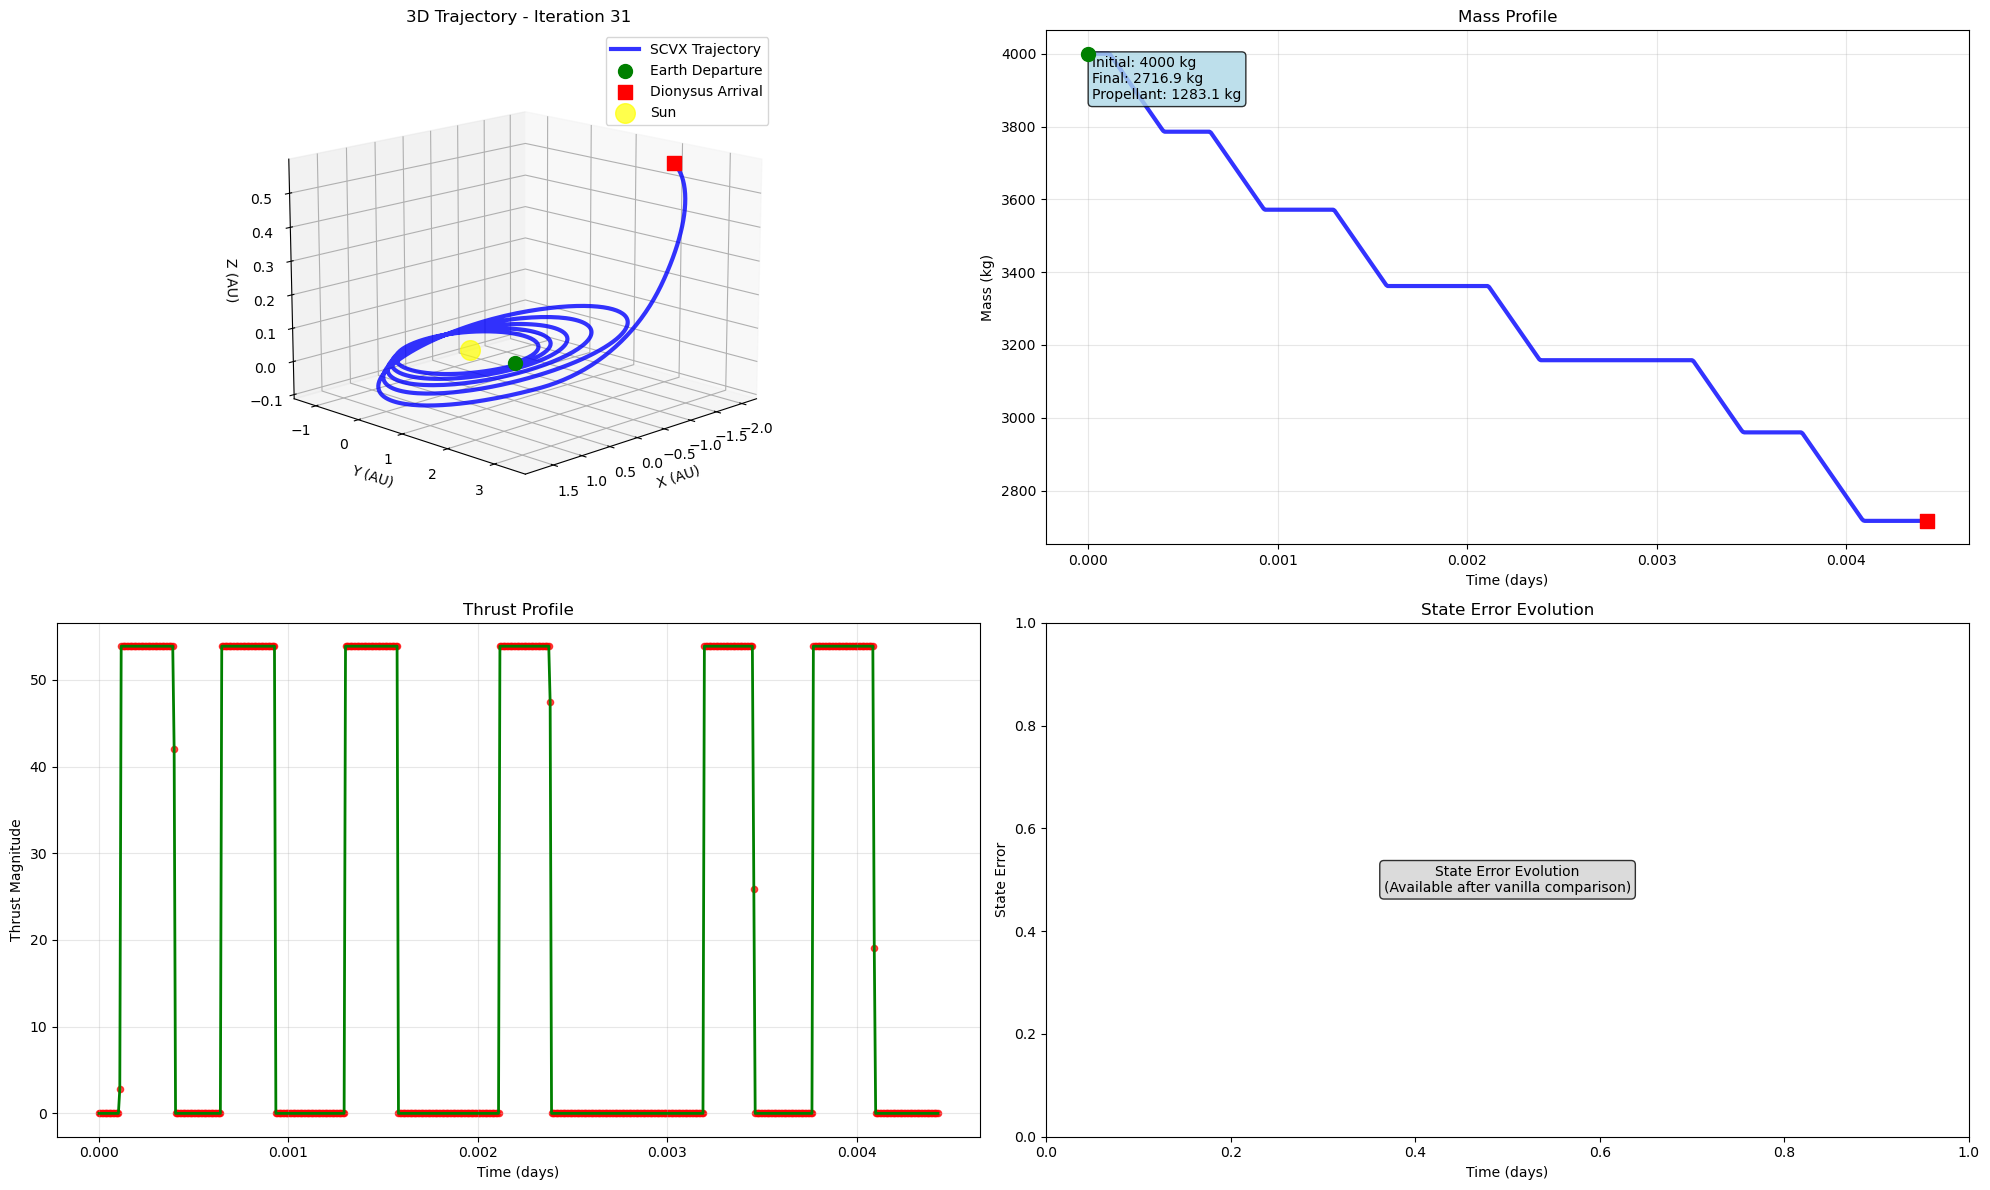

Iteration 31 completed. Converged: False
--- Iteration 32 ---
Linear cost: 3.818014e-01
Nonlinear cost: 3.826585e-01
Iteration 32 completed. Converged: False
--- Iteration 33 ---
Linear cost: 3.818014e-01
Nonlinear cost: 3.826585e-01
Iteration 32 completed. Converged: False
--- Iteration 33 ---
Linear cost: 3.817998e-01
Nonlinear cost: 3.846800e-01
Iteration 33 completed. Converged: False
--- Iteration 34 ---
Linear cost: 3.817998e-01
Nonlinear cost: 3.846800e-01
Iteration 33 completed. Converged: False
--- Iteration 34 ---
Linear cost: 3.818007e-01
Nonlinear cost: 3.835575e-01
Iteration 34 completed. Converged: False
--- Iteration 35 ---
Linear cost: 3.818007e-01
Nonlinear cost: 3.835575e-01
Iteration 34 completed. Converged: False
--- Iteration 35 ---
Linear cost: 3.817955e-01
Nonlinear cost: 3.836808e-01
Iteration 35 completed. Converged: False
--- Iteration 36 ---
Linear cost: 3.817955e-01
Nonlinear cost: 3.836808e-01
Iteration 35 completed. Converged: False
--- Iteration 36 ---
Li

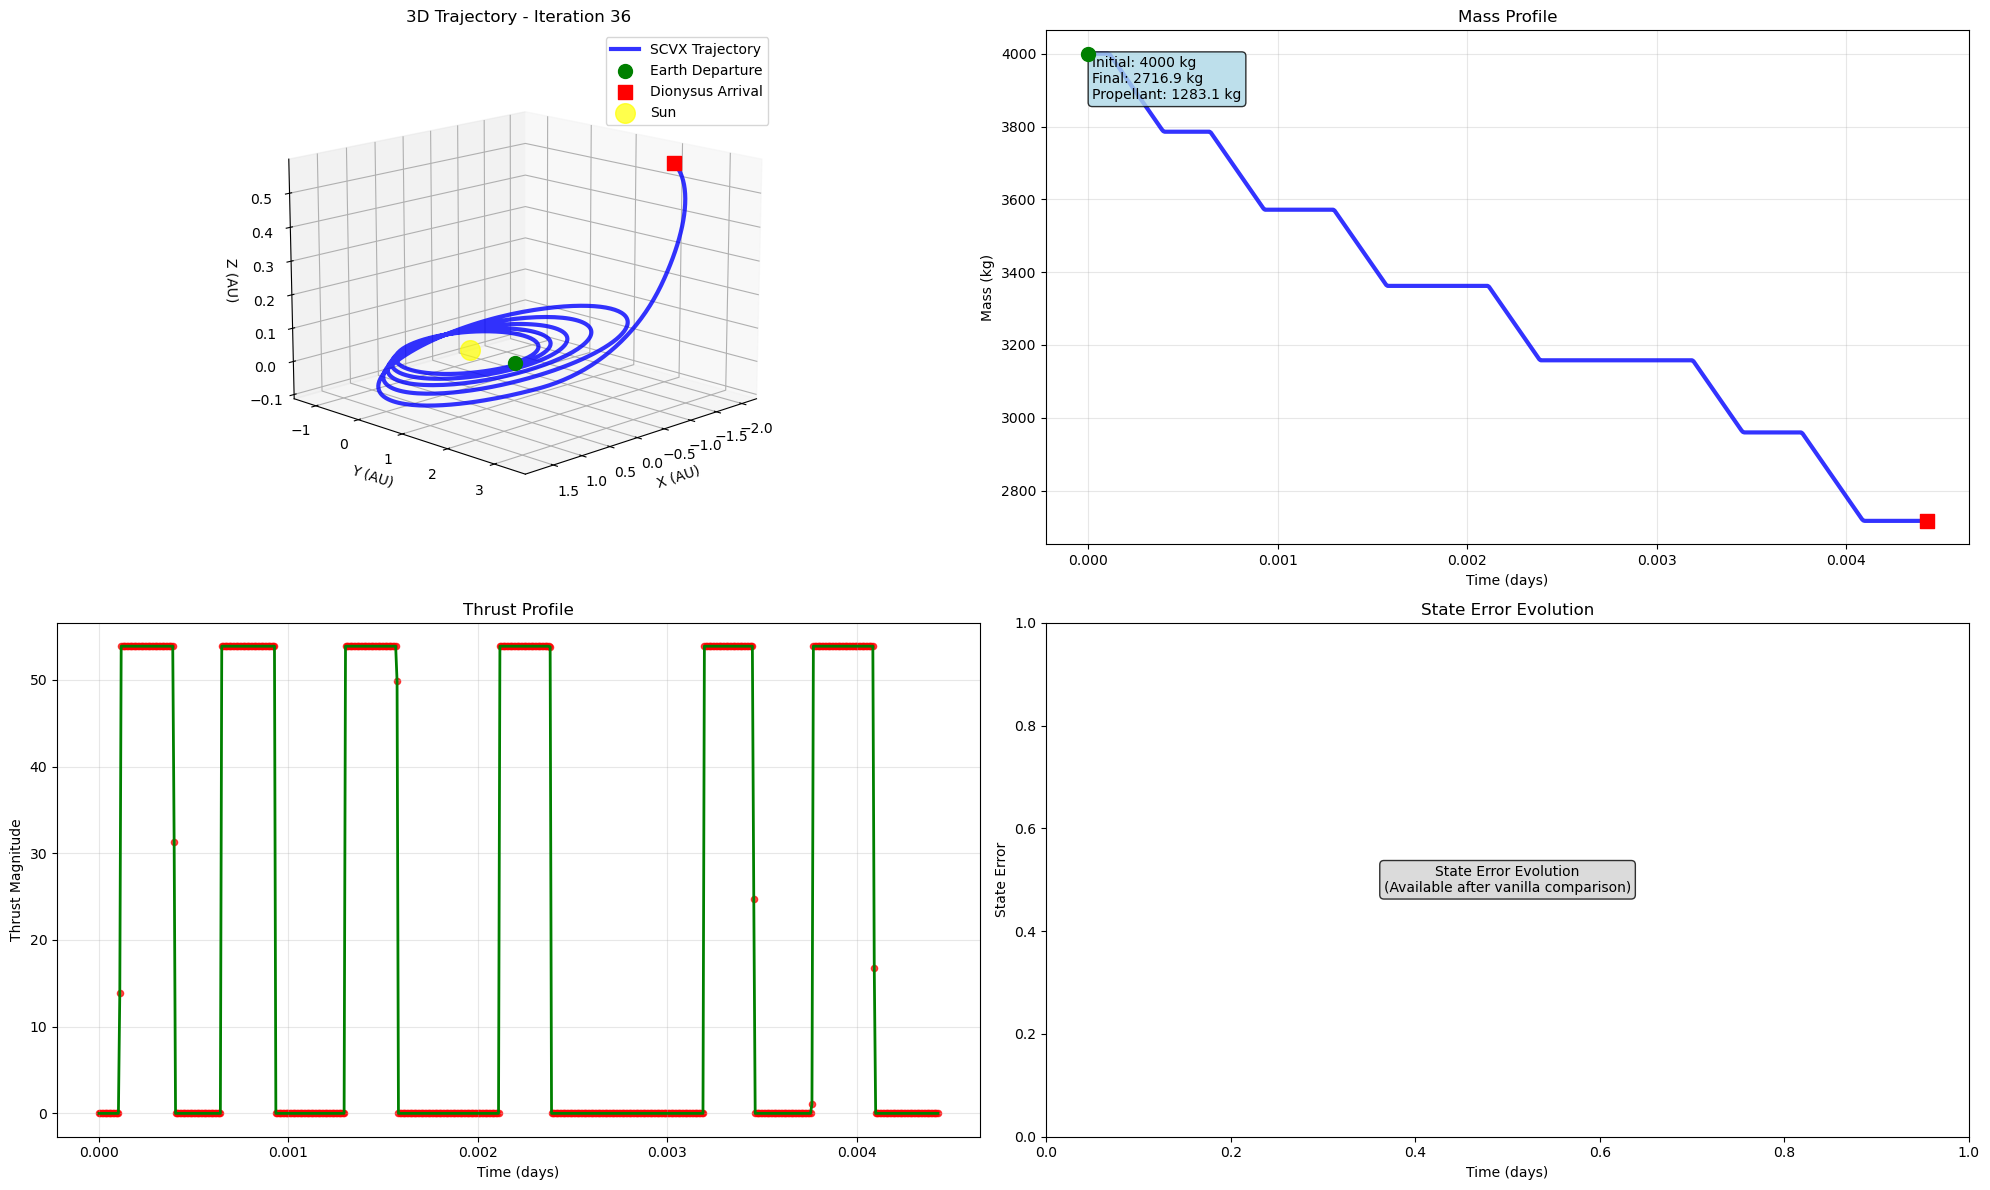

Iteration 36 completed. Converged: False
--- Iteration 37 ---
Linear cost: 3.818022e-01
Nonlinear cost: 3.825411e-01
Iteration 37 completed. Converged: False
--- Iteration 38 ---
Linear cost: 3.818022e-01
Nonlinear cost: 3.825411e-01
Iteration 37 completed. Converged: False
--- Iteration 38 ---
Linear cost: 3.817992e-01
Nonlinear cost: 3.826735e-01
Iteration 38 completed. Converged: False
--- Iteration 39 ---
Linear cost: 3.817992e-01
Nonlinear cost: 3.826735e-01
Iteration 38 completed. Converged: False
--- Iteration 39 ---
Linear cost: 3.818008e-01
Nonlinear cost: 3.822500e-01
Iteration 39 completed. Converged: False
--- Iteration 40 ---
Linear cost: 3.818008e-01
Nonlinear cost: 3.822500e-01
Iteration 39 completed. Converged: False
--- Iteration 40 ---
Linear cost: 3.818028e-01
Nonlinear cost: 3.820371e-01
Iteration 40 completed. Converged: False
--- Iteration 41 ---
Linear cost: 3.818028e-01
Nonlinear cost: 3.820371e-01
Iteration 40 completed. Converged: False
--- Iteration 41 ---
Li

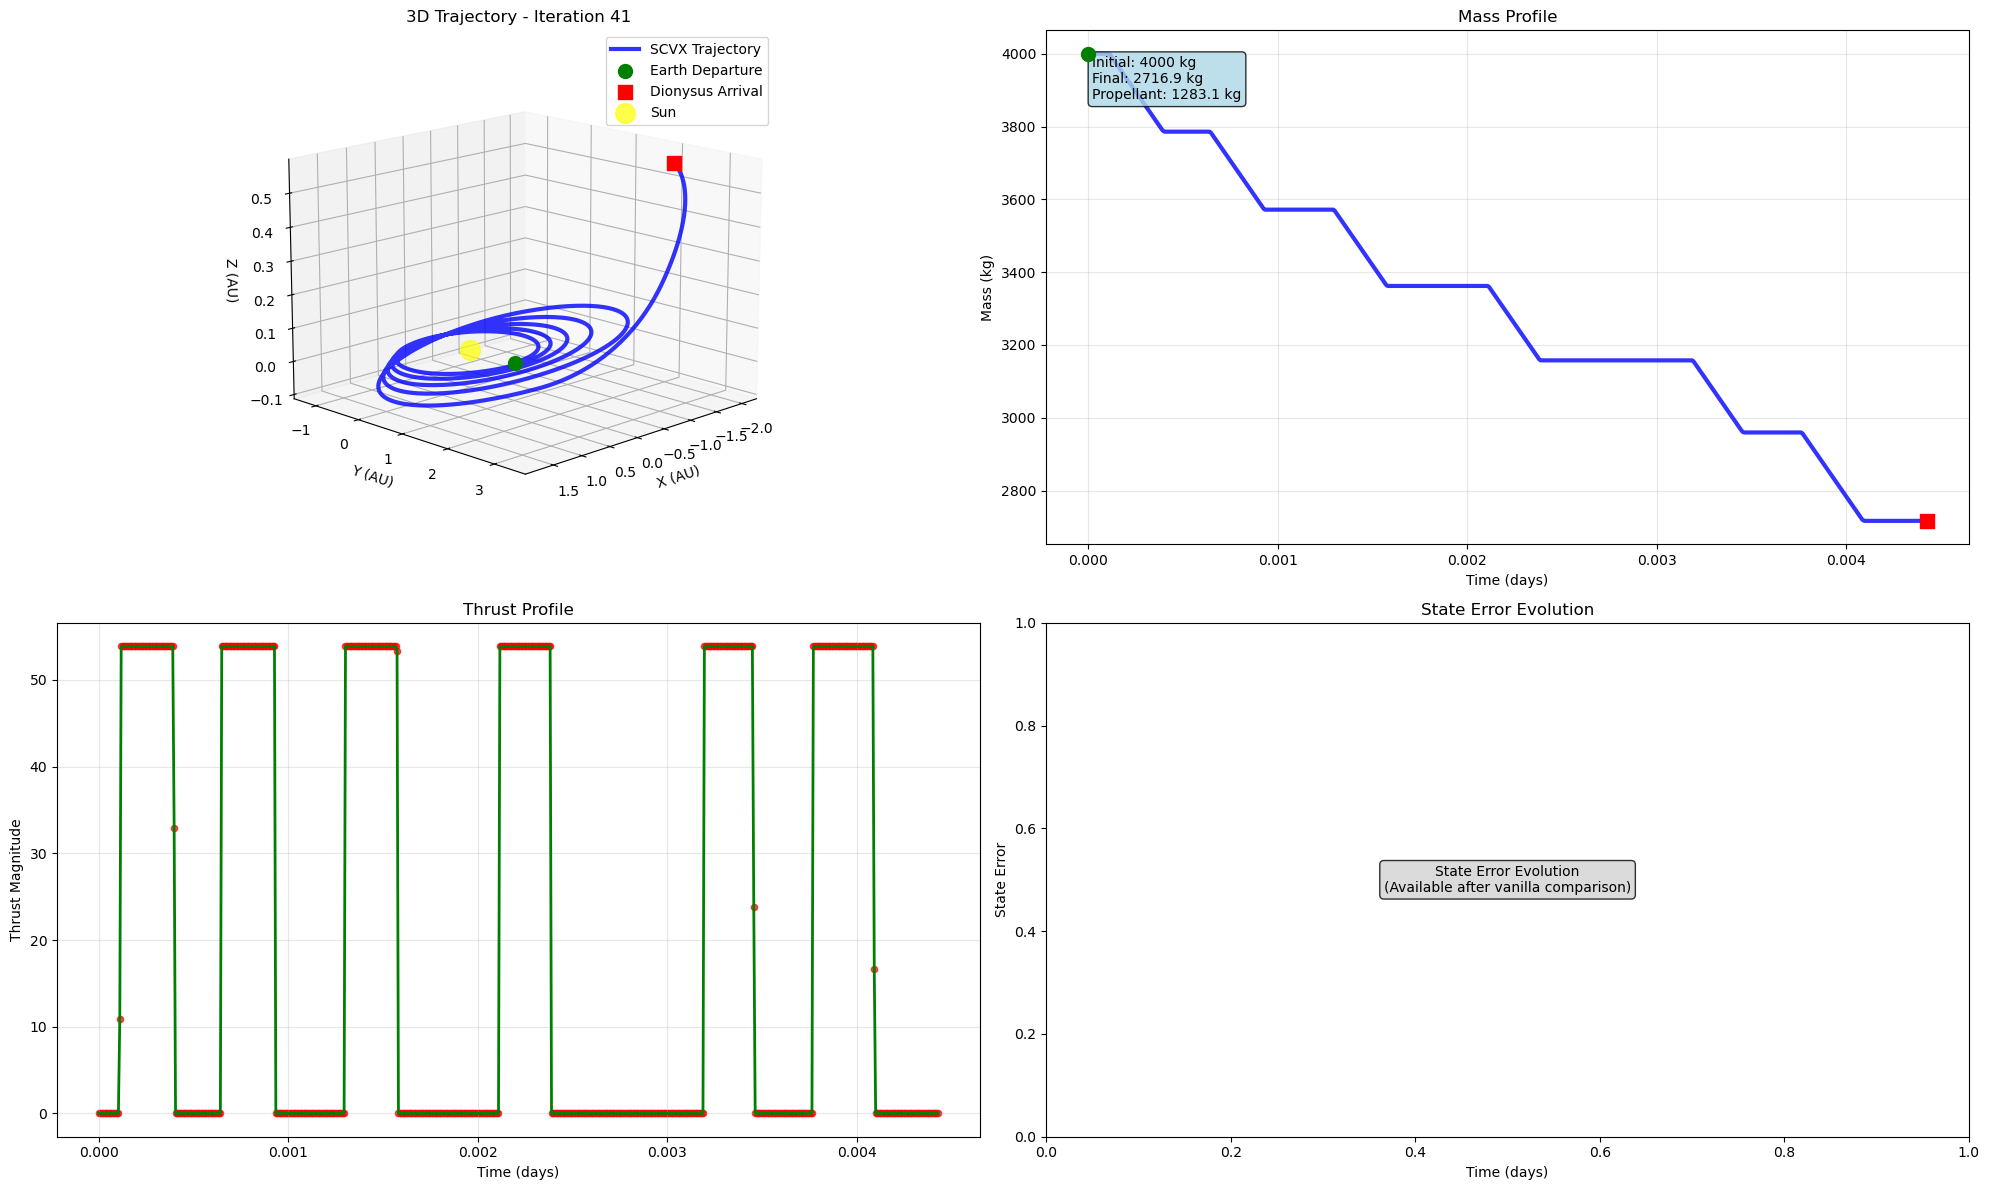

Iteration 41 completed. Converged: False
--- Iteration 42 ---
Linear cost: 3.818019e-01
Nonlinear cost: 3.820021e-01
Iteration 42 completed. Converged: False
--- Iteration 43 ---
Linear cost: 3.818019e-01
Nonlinear cost: 3.820021e-01
Iteration 42 completed. Converged: False
--- Iteration 43 ---
Linear cost: 3.818026e-01
Nonlinear cost: 3.820036e-01
Iteration 43 completed. Converged: False
--- Iteration 44 ---
Linear cost: 3.818026e-01
Nonlinear cost: 3.820036e-01
Iteration 43 completed. Converged: False
--- Iteration 44 ---
Linear cost: 3.818027e-01
Nonlinear cost: 3.818929e-01
Iteration 44 completed. Converged: False
--- Iteration 45 ---
Linear cost: 3.818027e-01
Nonlinear cost: 3.818929e-01
Iteration 44 completed. Converged: False
--- Iteration 45 ---
Linear cost: 3.818023e-01
Nonlinear cost: 3.818925e-01
Iteration 45 completed. Converged: True
=== Optimization Complete ===
Total iterations: 45
Final convergence status: True
Final trust region value: 2.283658e-02
Final mass: 2716.870

In [7]:
# Run Iterative Optimization Loop with Detailed Tracking

converged = False
iteration = 0
max_iterations = 250

# Track optimization progress
convergence_history = []
trust_region_history = []
final_mass_history = []
linear_cost_history = []
nonlinear_cost_history = []
propellant_used_history = []

while not converged and iteration < max_iterations:
    print(f"--- Iteration {iteration + 1} ---")
    
    try:
        # Run optimization step
        result = program.optimize()
        
        # Extract convergence status
        if isinstance(result, tuple):
            converged = bool(result[0])
        else:
            converged = bool(result)
        
        # Record convergence status
        convergence_history.append(converged)
        
        # Track final mass evolution
        final_mass = np.exp(program.z.value[-1])
        final_mass_history.append(final_mass)
        propellant_used = m0 - final_mass
        propellant_used_history.append(propellant_used)
        
        # Track linear and nonlinear costs
        linear_cost_history.append(float(program.linear_cost))
        print(f"Linear cost: {program.linear_cost:.6e}")
        
        nonlinear_cost_history.append(float(program.nonlinear_cost))
        print(f"Nonlinear cost: {program.nonlinear_cost:.6e}")
        
        # Track trust region information
        trust_region_val = program.trust_region[0] if len(program.trust_region) > 0 else 0
        trust_region_history.append(trust_region_val)
        
        # Plot optimization progress every 5 iterations
        if iteration % 5 == 0:
            plot_optimization_progress(program, iteration, AU, TU, t_f_days, m0, c_val, mu, CoordinateConversion)
        
        print(f"Iteration {iteration + 1} completed. Converged: {converged}")
        
    except Exception as e:
        print(f"Iteration {iteration + 1} failed: {e}")
        break
    
    iteration += 1

# Print final results
print(f"=== Optimization Complete ===")
print(f"Total iterations: {iteration}")
print(f"Final convergence status: {converged}")
print(f"Final trust region value: {trust_region_history[-1]:.6e}")
print(f"Final mass: {final_mass_history[-1]:.4f} kg")
print(f"Propellant efficiency: {(m0 - final_mass_history[-1])/m0*100:.2f}% of initial mass")

🎯 SCVX vs Vanilla Two-Body Trajectory Comparison
Integrating vanilla Two-Body system with SCVX control (segmented approach)...
✅ All 10 segments integrated successfully!
MEE state error: 3.04e-05
Position error: 5.73e-05 AU = 8570.195 km
Velocity error: 4.12e-06 AU/TU = 0.000123 km/s
Mass error: 0.028105 kg (0.0010%)
✅ All 10 segments integrated successfully!
MEE state error: 3.04e-05
Position error: 5.73e-05 AU = 8570.195 km
Velocity error: 4.12e-06 AU/TU = 0.000123 km/s
Mass error: 0.028105 kg (0.0010%)


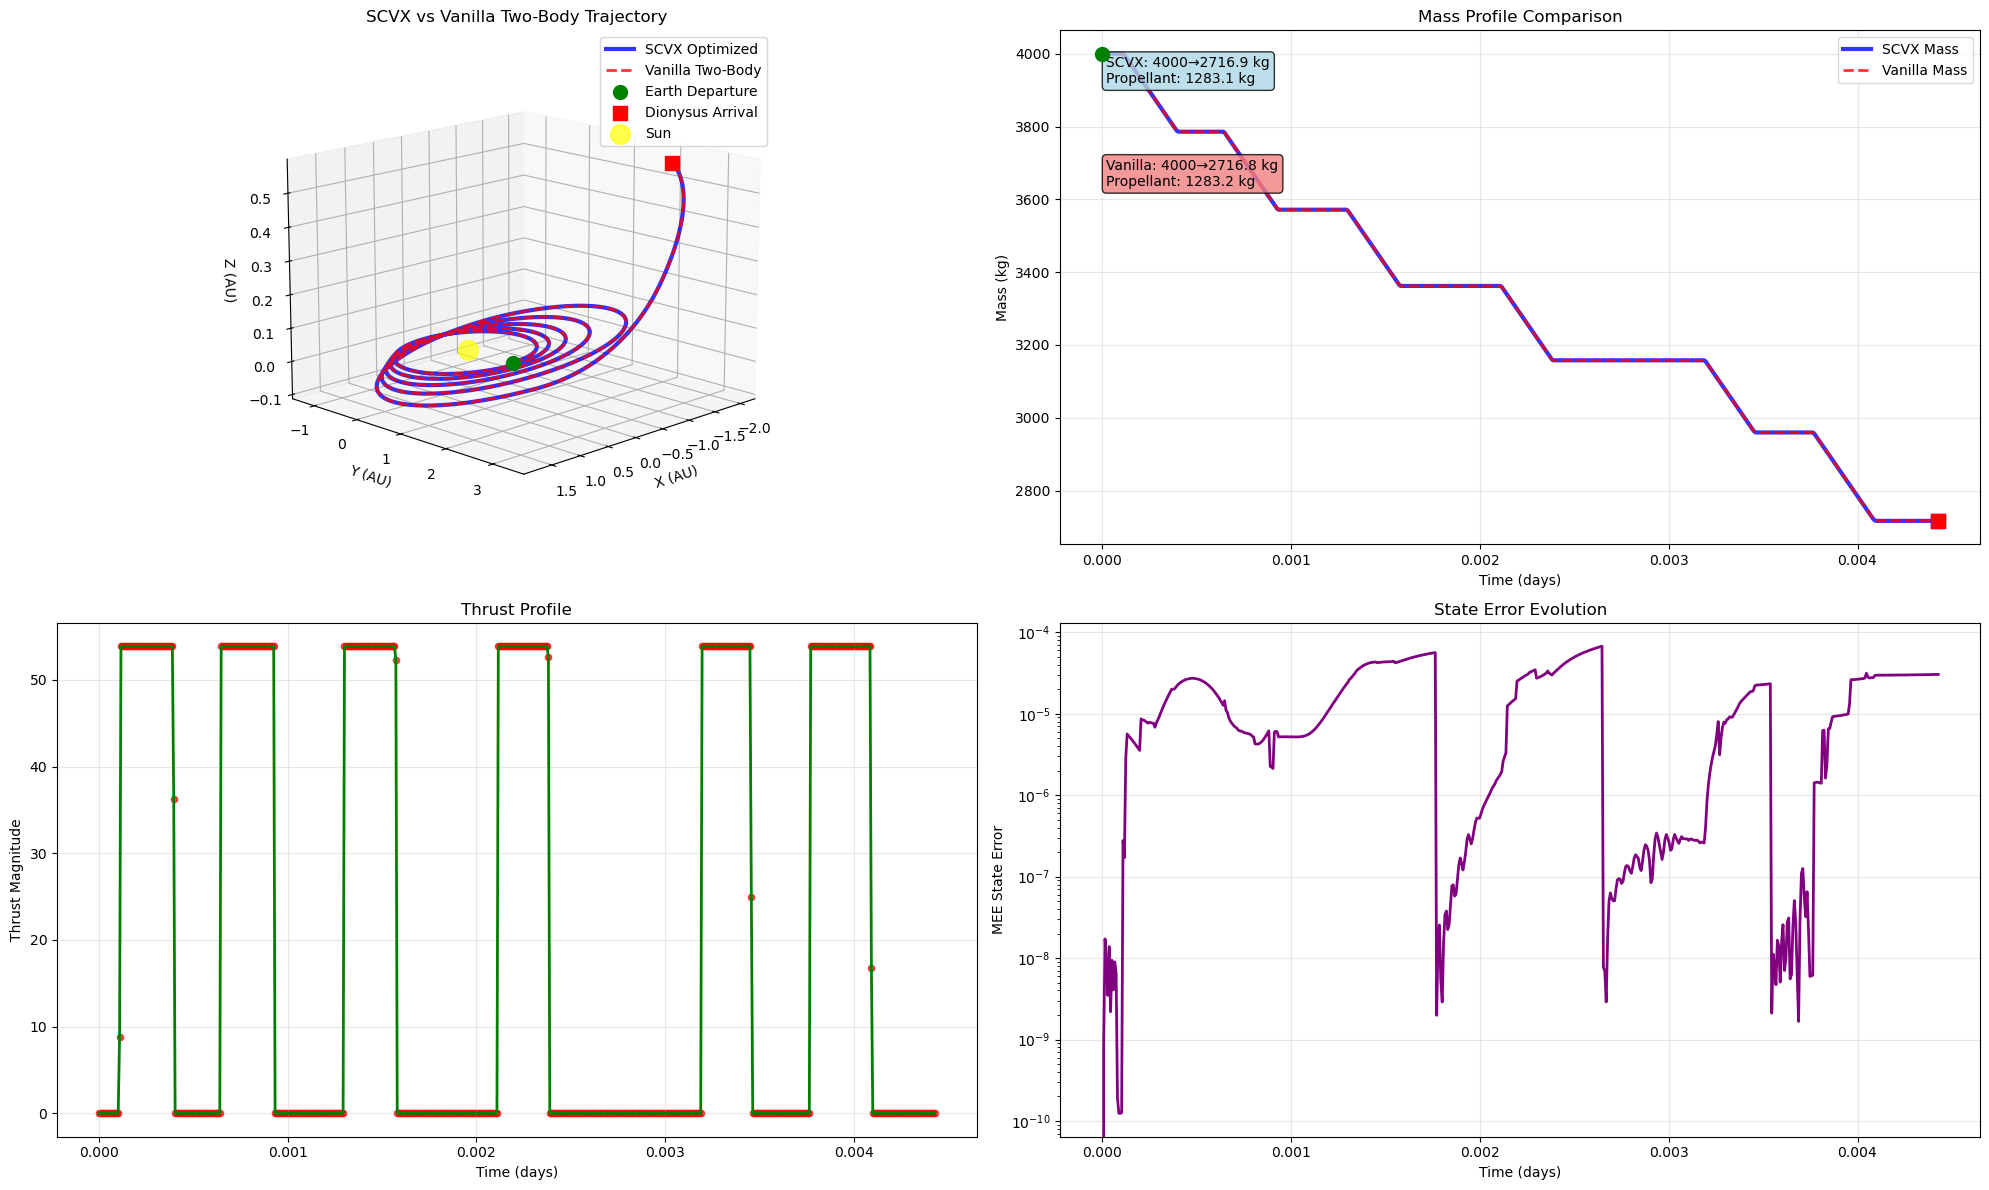

🎉 Earth-Dionysus trajectory comparison complete!
Max MEE state difference: 6.75e-05
Final propellant savings: 0.03 kg


In [8]:
# SCVX vs Vanilla Two-Body Trajectory Comparison

print("🎯 SCVX vs Vanilla Two-Body Trajectory Comparison")

# Extract SCVX trajectory
scvx_trajectory = program.x.value.T  # Convert to (6, N) format
N_points = scvx_trajectory.shape[1]

# Time vector
dt_scvx = program.s.value
time_scvx = np.concatenate(([0], np.cumsum(dt_scvx)))*program.dt

# Transform tau to proper physical units
scaling_factor = (np.exp(program.z_p) / 
                 np.concatenate([program.s.value, [program.s.value[-1]]]))
thrust_control = program.tau.value * scaling_factor[:, np.newaxis]

# Define vanilla ODE system with SCVX control
def vanilla_ode_with_control(t, state_mass):
    state = state_mass[:6]  # MEE state
    mass = state_mass[6]    # mass = exp(z)
    
    control_vec = np.array([
        np.interp(t, time_scvx, thrust_control[:, 0]),  # x-component
        np.interp(t, time_scvx, thrust_control[:, 1]),  # y-component
        np.interp(t, time_scvx, thrust_control[:, 2])   # z-component
    ])

    # Get state derivative from vanilla dynamics
    state_dot = vanilla_twobody.state_dot(state, control_vec, mass)
    
    # Calculate mass derivative: dm/dt = -|control|/c
    control_mag = np.linalg.norm(control_vec)
    mass_dot = -(control_mag / c_val)
    return np.concatenate([state_dot, [mass_dot]])

# Integrate vanilla system with SCVX control using segmented approach for stability
print("Integrating vanilla Two-Body system with SCVX control (segmented approach)...")

n_segments = 10
segment_size = len(time_scvx) // n_segments
vanilla_trajectory_segments = []
vanilla_mass_segments = []

for seg in range(n_segments):
    # Determine segment indices
    start_idx = seg * segment_size
    if seg == n_segments - 1:
        end_idx = len(time_scvx) - 1
    else:
        end_idx = (seg + 1) * segment_size
    
    # Get time range for this segment
    t_start = time_scvx[start_idx]
    t_end = time_scvx[end_idx]
    t_eval_segment = time_scvx[start_idx:end_idx+1]
    
    # Initial conditions for this segment
    if seg == 0:
        initial_state_segment = np.concatenate([scvx_trajectory[:, start_idx], [np.exp(program.z.value[start_idx])]])
    elif seg % 2 == 0:
        initial_state_segment = np.concatenate([scvx_trajectory[:, start_idx], [np.exp(program.z.value[start_idx])]])
    else:
        prev_trajectory = vanilla_trajectory_segments[-1]
        prev_mass = vanilla_mass_segments[-1]
        initial_state_segment = np.concatenate([prev_trajectory[:, -1], [prev_mass[-1]]])
    
    # Integrate this segment
    sol_segment = scipy.integrate.solve_ivp(
        vanilla_ode_with_control,
        [t_start, t_end],
        initial_state_segment,
        t_eval=t_eval_segment,
        rtol=1e-10,
        atol=1e-12
    )
    
    if sol_segment.success:
        if seg == 0:
            vanilla_trajectory_segments.append(sol_segment.y[:6, :])
            vanilla_mass_segments.append(sol_segment.y[6, :])
        else:
            vanilla_trajectory_segments.append(sol_segment.y[:6, 1:])  # Skip first point
            vanilla_mass_segments.append(sol_segment.y[6, 1:])        # Skip first point
    else:
        print(f"❌ Segment {seg + 1} integration failed: {sol_segment.message}")
        break

# Combine all segments
if len(vanilla_trajectory_segments) == n_segments:
    print(f"✅ All {n_segments} segments integrated successfully!")
    
    vanilla_trajectory = np.concatenate(vanilla_trajectory_segments, axis=1)
    vanilla_mass = np.concatenate(vanilla_mass_segments)
    
    # Compare final states
    scvx_final = scvx_trajectory[:, -1]
    vanilla_final = vanilla_trajectory[:, -1]
    mee_error = np.linalg.norm(scvx_final - vanilla_final)
    
    # Convert to Cartesian for position/velocity errors
    scvx_cart_final = CoordinateConversion.sv_from_mee(scvx_final, mu)
    vanilla_cart_final = CoordinateConversion.sv_from_mee(vanilla_final, mu)
    cart_pos_error = np.linalg.norm(scvx_cart_final[:3] - vanilla_cart_final[:3])
    cart_vel_error = np.linalg.norm(scvx_cart_final[3:] - vanilla_cart_final[3:])
    
    print(f"MEE state error: {mee_error:.2e}")
    print(f"Position error: {cart_pos_error:.2e} AU = {cart_pos_error * AU:.3f} km")
    print(f"Velocity error: {cart_vel_error:.2e} AU/TU = {cart_vel_error * AU/TU:.6f} km/s")
    
    # Mass comparison
    scvx_final_mass = np.exp(program.z.value[-1])
    mass_error = abs(scvx_final_mass - vanilla_mass[-1])
    print(f"Mass error: {mass_error:.6f} kg ({mass_error/scvx_final_mass*100:.4f}%)")
    
    # Create comprehensive comparison plots
    propellant_scvx, propellant_vanilla, state_errors = plot_comprehensive_comparison(
        program, scvx_trajectory, vanilla_trajectory, vanilla_mass, 
        time_scvx, thrust_control, AU, TU, t_f_days, m0, mu, CoordinateConversion)
    
    print(f"🎉 Earth-Dionysus trajectory comparison complete!")
    print(f"Max MEE state difference: {np.max(state_errors):.2e}")
    print(f"Final propellant savings: {propellant_vanilla - propellant_scvx:.2f} kg")
    
else:
    print(f"❌ Integration failed after {len(vanilla_trajectory_segments)} segments")